In [1]:
import pandas as pd
import numpy as np
import datetime as dt

def time_weighted_mean(data, period):
    years = [i for i in range(pd.to_datetime(period[0]).year, pd.to_datetime(period[1]).year + 1)]
    
    weights = np.array(pd.to_datetime(f'{years[0]}-12-31').timetuple().tm_yday - pd.to_datetime(period[0]).timetuple().tm_yday)
    for i in years[1:len(years)-1]:
        weights = np.append(weights, pd.to_datetime(f'{i}-12-31').timetuple().tm_yday)
    weights = np.append(weights, pd.to_datetime(period[1]).timetuple().tm_yday)
    weights = weights / weights.sum()
    
    res = (np.array(data.iloc[[i in years for i in data.year], 1].to_list()) * weights).sum()
    return res

In [2]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import cluster
import seaborn as sns
%matplotlib inline

In [3]:
countries = ['Argentina', 'Brazil', 'Chile', 'China', 'Colombia', 'Egypt, Arab Rep.', 'India', 'Indonesia',
             'Malaysia', 'Mexico', 'Philippines', 'Pakistan', 'Peru', 'Russian Federation', 'Thailand', 
             'Turkey', 'South Africa']
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
fp = ['2010-06-30', '2012-08-01']
sp = ['2012-06-20', '2015-01-28']
tp = ['2014-10-30', '2019-03-20']
p = [fp, sp, tp]
data_imp = pd.read_excel('data_imp_var.xlsx')

data_imp.loc[:, 'impulse'] = [i.split('_')[0] for i in data_imp.iloc[:, 13]]
data_imp.loc[:, 'freq'] = [i.split('_')[1] for i in data_imp.iloc[:,13]]
data_imp.loc[:, 'period'] = [i.split('_')[2] for i in data_imp.iloc[:,13]]
data_imp.loc[:, 'country'] = [i.split('_')[3] for i in data_imp.iloc[:,13]]
data_imp.loc[:, 'ci'] = [i.split('_')[4] for i in data_imp.iloc[:,13]]

trilemma = pd.read_excel('https://web.pdx.edu/~ito/trilemma_indexes_update2020.xlsx') \
        .dropna().set_axis(['id', 'year', 'ers', 'mi', 'fo', 'name'], axis = 1) \
        .query('year in [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]', engine = 'python')
trilemma = trilemma.loc[[i in countries for i in trilemma.name], :].reset_index(drop = True)
trilemma = pd.concat([trilemma, 
           trilemma.query('name == "Egypt, Arab Rep." and year == 2017').copy(),
           trilemma.query('name == "Egypt, Arab Rep." and year == 2017').copy()]).reset_index(drop = True)
trilemma.iloc[trilemma.shape[0]-2:trilemma.shape[0], 1] = [2018, 2019]
trilemma = pd.concat([trilemma, 
           trilemma.query('name == "Indonesia" and year == 2016').copy(),
           trilemma.query('name == "Indonesia" and year == 2016').copy(),
           trilemma.query('name == "Indonesia" and year == 2016').copy()]).reset_index(drop = True)
trilemma.iloc[trilemma.shape[0]-3:trilemma.shape[0], 1] = [2017, 2018, 2019]

keys = ['ARGENTINA', 'PAKISTAN','RUSSIA', 'BRAZIL', 'CHILE', 'CHINA', 'COLOMBIA', 'EGYPT', 'INDIA', 
        'INDIA.DOMESTIC', 'INDONESIA','MALAYSIA', 'MEXICO', 'PERU', 'PHILIPPINES', 'SOUTH.AFRICA', 'THAILAND', 'TURKEY']
countries = {k:v for k,v in zip(keys, [countries[i] for i in [0, 11, 13, 1, 2, 3, 4, 5, 6, 6, 7, 8, 9, 12, 10, 16, 14, 15]])}
countries_rus = {k:v for k, v in zip(countries.keys(),['Аргентина', 'Пакистан', 'Россия', 'Бразилия', 'Чили', 'Китай',
                                                       'Колумбия',
                                                      'Египет', 'Индия', 'Индия, только резиденты', 'Индонезия', 'Малайзия', 
                                                      'Мексика', 'Перу', 'Филиппины', 'Южная Африка', 'Тайланд', 'Турция'])}

fd = pd.read_excel('C:/Users/vasil/YandexDisk/D is not for Dragons/data/findev and expdiv/FD.xlsx')
fd = fd.loc[[i in countries.values() for i in fd.country], :].copy()

frequancy = {'weekly':'недельные данные', 'daily':'дневные данные'}
segment = {'1': 'первый сегмент', '2':'второй сегмент', '3':'третий сегмент'}
impulse = {'10y': '10-летней доходности казначейских облигаций', 'DXY':'индекса доллара', 
           'SP': 'S&P 500', 'VIX':'индекса волатильности'}

In [4]:
IMP = data_imp.query('ci == "irf"').copy()
IMP.loc[:,'cummulative'] = IMP.iloc[:, 0:13].apply(sum, axis = 1).copy()
IMP.loc[:, 'instant'] = IMP.iloc[:, 0].copy()
IMP = IMP.iloc[:, 14:].copy()
IMP.loc[:, 'ers'] = [time_weighted_mean(trilemma.query(f'name == "{countries[k]}"').loc[:, ['year','ers']], p[int(v)-1]) 
                    for v,k in zip(IMP.period, IMP.country)]
IMP.loc[:, 'mi'] = [time_weighted_mean(trilemma.query(f'name == "{countries[k]}"').loc[:, ['year','mi']], p[int(v)-1]) 
                    for v,k in zip(IMP.period, IMP.country)]
IMP.loc[:, 'fo'] = [time_weighted_mean(trilemma.query(f'name == "{countries[k]}"').loc[:, ['year','fo']], p[int(v)-1]) 
                    for v,k in zip(IMP.period, IMP.country)]
IMP.loc[:, 'fd'] = [time_weighted_mean(fd.query(f'country == "{countries[k]}"').loc[:, ['year','FD']], p[int(v)-1]) 
                    for v,k in zip(IMP.period, IMP.country)]
IMP = IMP.sort_values(by = ['impulse'], ascending = True).reset_index(drop = True)

In [5]:
IMP_a = IMP.query('country != "INDIA.DOMESTIC"')

In [6]:

cluster_data = IMP_a\
    .loc[[i == '10y' and j == 'daily' for i, j in zip(IMP_a.impulse, IMP_a.freq)], ['ers', 'mi', 'fo', 'fd', 'period', 'country']]
res_4 = pd.DataFrame(columns = ['period', 'country', 'cluster', 'random_state'])

X = cluster_data.loc[:, ['ers', 'mi', 'fo', 'fd']].copy().to_numpy()
var = X.var(axis = 0).sum()

r_s = 0
count = 0
nc = 4
var_4 = pd.DataFrame(columns = ['var', 'observations_added', 'randon_state'])
while count <= 1000:

    cluster_sample = cluster_data.copy()

    kmeans = cluster.KMeans(n_clusters=nc, random_state=r_s).fit(X)

    cluster_sample.loc[:, 'cluster'] = kmeans.labels_
    var_c = 1 - (cluster_sample.groupby('cluster') \
            .agg({i: 'var' for i in ['ers', 'mi', 'fo', 'fd']}).sum(axis = 1).to_numpy()  \
            *np.unique(kmeans.labels_, return_counts=True)[1]/(cluster_data.shape[0]*var)).sum()
    
    lst_c = cluster_sample.groupby('cluster').agg({'period':'value_counts'}).rename(columns = {'period':'n_values'})

    if ((lst_c.reset_index().groupby('cluster').agg({'period':'count'}) < 3).sum() == 0).bool():
        dist = np.array([])
        for i in range(nc):
            M = cluster_sample.query(f'cluster == {i}').loc[:, ['ers', 'mi', 'fo', 'fd']].to_numpy()
            dist = np.append(dist, np.mean((M - np.reshape(kmeans.cluster_centers_[i], (1, 4)))**2, axis = 1))
        cluster_sample.loc[:, 'dist'] = dist
        observations_added = 0
        for i in range(nc):
            lst_add = (lst_c.loc[(i,)] - lst_c.loc[(i,)].max()).abs()
            for p in ['1', '2', '3']:

                addition = cluster_sample.query(f'cluster == {i}').query(f'period == "{int(p)}"') \
                                        .sort_values(by = 'dist', ascending = True).copy()

                addition = pd.concat([addition]*(cluster_data.shape[0]//addition.shape[0]), ignore_index = True) \
                                                .iloc[0:int(lst_add.loc[p][0]),:]
                observations_added = observations_added + addition.shape[0]
                cluster_sample = pd.concat([cluster_sample, addition])
                
        print(f'The within variance share {var_c}, for the random state "{r_s}" {observations_added} observations added')
        cluster_sample.loc[:, 'random_state'] = r_s
        res_4 = pd.concat([res_4, cluster_sample.loc[:, ['period', 'country', 'cluster', 'random_state']]], ignore_index = True)
        count , r_s = count + 1, r_s + 1
        var_4 = pd.concat([var_4, pd.DataFrame({'var':var_c, 'observations_added':observations_added, 'randon_state':r_s}, \
                                               index = [0])])
    else:
        print(f'drop random state {r_s}')
        r_s = r_s + 1
    print(f'=====================================  {count}  ====================================')

The within variance share 0.6119191083212241, for the random state "0" 15 observations added
=====================================  1  ====================================
The within variance share 0.6119191083212241, for the random state "1" 15 observations added
=====================================  2  ====================================
The within variance share 0.606200154729221, for the random state "2" 15 observations added
=====================================  3  ====================================
The within variance share 0.6119191083212241, for the random state "3" 15 observations added
=====================================  4  ====================================
The within variance share 0.6103582814245591, for the random state "4" 15 observations added
=====================================  5  ====================================
The within variance share 0.6121934497572507, for the random state "5" 15 observations added
=====================================  6  ======

The within variance share 0.6103582814245591, for the random state "49" 15 observations added
=====================================  50  ====================================
The within variance share 0.6119191083212241, for the random state "50" 15 observations added
=====================================  51  ====================================
The within variance share 0.611314291858161, for the random state "51" 15 observations added
=====================================  52  ====================================
The within variance share 0.6119191083212241, for the random state "52" 15 observations added
=====================================  53  ====================================
The within variance share 0.6119191083212241, for the random state "53" 15 observations added
=====================================  54  ====================================
The within variance share 0.6119191083212241, for the random state "54" 15 observations added
=====================================

The within variance share 0.6119191083212241, for the random state "98" 15 observations added
=====================================  99  ====================================
The within variance share 0.611314291858161, for the random state "99" 15 observations added
=====================================  100  ====================================
The within variance share 0.6119191083212241, for the random state "100" 15 observations added
=====================================  101  ====================================
The within variance share 0.6119191083212241, for the random state "101" 15 observations added
=====================================  102  ====================================
The within variance share 0.6119191083212241, for the random state "102" 15 observations added
=====================================  103  ====================================
The within variance share 0.6133859651458304, for the random state "103" 15 observations added
=============================

The within variance share 0.6133859651458304, for the random state "145" 15 observations added
=====================================  146  ====================================
The within variance share 0.6119191083212241, for the random state "146" 15 observations added
=====================================  147  ====================================
The within variance share 0.611314291858161, for the random state "147" 15 observations added
=====================================  148  ====================================
The within variance share 0.6119191083212241, for the random state "148" 15 observations added
=====================================  149  ====================================
The within variance share 0.6119191083212241, for the random state "149" 15 observations added
=====================================  150  ====================================
The within variance share 0.6119191083212241, for the random state "150" 15 observations added
==========================

The within variance share 0.6085001496044484, for the random state "193" 12 observations added
=====================================  194  ====================================
The within variance share 0.6119191083212241, for the random state "194" 15 observations added
=====================================  195  ====================================
The within variance share 0.611314291858161, for the random state "195" 15 observations added
=====================================  196  ====================================
The within variance share 0.611314291858161, for the random state "196" 15 observations added
=====================================  197  ====================================
The within variance share 0.6119191083212242, for the random state "197" 15 observations added
=====================================  198  ====================================
The within variance share 0.6119191083212241, for the random state "198" 15 observations added
===========================

The within variance share 0.6119191083212241, for the random state "241" 15 observations added
=====================================  242  ====================================
The within variance share 0.611314291858161, for the random state "242" 15 observations added
=====================================  243  ====================================
The within variance share 0.6079319475210603, for the random state "243" 12 observations added
=====================================  244  ====================================
The within variance share 0.6119191083212241, for the random state "244" 15 observations added
=====================================  245  ====================================
The within variance share 0.611314291858161, for the random state "245" 15 observations added
=====================================  246  ====================================
The within variance share 0.6119191083212241, for the random state "246" 15 observations added
===========================

The within variance share 0.609788977120429, for the random state "289" 15 observations added
=====================================  290  ====================================
The within variance share 0.6119191083212241, for the random state "290" 15 observations added
=====================================  291  ====================================
The within variance share 0.611314291858161, for the random state "291" 15 observations added
=====================================  292  ====================================
The within variance share 0.6119191083212241, for the random state "292" 15 observations added
=====================================  293  ====================================
The within variance share 0.609788977120429, for the random state "293" 15 observations added
=====================================  294  ====================================
The within variance share 0.6079319475210603, for the random state "294" 12 observations added
============================

The within variance share 0.6119191083212241, for the random state "337" 15 observations added
=====================================  338  ====================================
The within variance share 0.6119191083212241, for the random state "338" 15 observations added
=====================================  339  ====================================
The within variance share 0.6119191083212241, for the random state "339" 15 observations added
=====================================  340  ====================================
The within variance share 0.6119191083212241, for the random state "340" 15 observations added
=====================================  341  ====================================
The within variance share 0.6119191083212241, for the random state "341" 15 observations added
=====================================  342  ====================================
The within variance share 0.6119191083212241, for the random state "342" 15 observations added
=========================

The within variance share 0.609788977120429, for the random state "385" 15 observations added
=====================================  386  ====================================
The within variance share 0.6119191083212241, for the random state "386" 15 observations added
=====================================  387  ====================================
The within variance share 0.6058288684085971, for the random state "387" 12 observations added
=====================================  388  ====================================
The within variance share 0.6119191083212241, for the random state "388" 15 observations added
=====================================  389  ====================================
The within variance share 0.6119191083212241, for the random state "389" 15 observations added
=====================================  390  ====================================
The within variance share 0.6119191083212241, for the random state "390" 15 observations added
==========================

The within variance share 0.611314291858161, for the random state "432" 15 observations added
=====================================  433  ====================================
The within variance share 0.6119191083212241, for the random state "433" 15 observations added
=====================================  434  ====================================
The within variance share 0.6119191083212241, for the random state "434" 15 observations added
=====================================  435  ====================================
The within variance share 0.6133859651458304, for the random state "435" 15 observations added
=====================================  436  ====================================
The within variance share 0.6119191083212241, for the random state "436" 15 observations added
=====================================  437  ====================================
The within variance share 0.6119191083212241, for the random state "437" 15 observations added
==========================

The within variance share 0.6119191083212241, for the random state "480" 15 observations added
=====================================  481  ====================================
The within variance share 0.6119191083212241, for the random state "481" 15 observations added
=====================================  482  ====================================
The within variance share 0.6119191083212241, for the random state "482" 15 observations added
=====================================  483  ====================================
The within variance share 0.6119191083212241, for the random state "483" 15 observations added
=====================================  484  ====================================
The within variance share 0.6119191083212241, for the random state "484" 15 observations added
=====================================  485  ====================================
The within variance share 0.6119191083212241, for the random state "485" 15 observations added
=========================

The within variance share 0.6133859651458304, for the random state "528" 15 observations added
=====================================  529  ====================================
The within variance share 0.6119191083212241, for the random state "529" 15 observations added
=====================================  530  ====================================
The within variance share 0.611314291858161, for the random state "530" 15 observations added
=====================================  531  ====================================
The within variance share 0.611314291858161, for the random state "531" 15 observations added
=====================================  532  ====================================
The within variance share 0.6119191083212241, for the random state "532" 15 observations added
=====================================  533  ====================================
The within variance share 0.6119191083212241, for the random state "533" 15 observations added
===========================

The within variance share 0.6133859651458304, for the random state "576" 15 observations added
=====================================  577  ====================================
The within variance share 0.6133859651458304, for the random state "577" 15 observations added
=====================================  578  ====================================
The within variance share 0.6119191083212241, for the random state "578" 15 observations added
=====================================  579  ====================================
The within variance share 0.6119191083212241, for the random state "579" 15 observations added
=====================================  580  ====================================
The within variance share 0.6119191083212241, for the random state "580" 15 observations added
=====================================  581  ====================================
The within variance share 0.611314291858161, for the random state "581" 15 observations added
==========================

The within variance share 0.611314291858161, for the random state "624" 15 observations added
=====================================  625  ====================================
The within variance share 0.6119191083212241, for the random state "625" 15 observations added
=====================================  626  ====================================
The within variance share 0.6119191083212241, for the random state "626" 15 observations added
=====================================  627  ====================================
The within variance share 0.6085001496044484, for the random state "627" 12 observations added
=====================================  628  ====================================
The within variance share 0.6119191083212241, for the random state "628" 15 observations added
=====================================  629  ====================================
The within variance share 0.6119191083212241, for the random state "629" 15 observations added
==========================

The within variance share 0.6119191083212241, for the random state "671" 15 observations added
=====================================  672  ====================================
The within variance share 0.6119191083212241, for the random state "672" 15 observations added
=====================================  673  ====================================
The within variance share 0.6119191083212241, for the random state "673" 15 observations added
=====================================  674  ====================================
The within variance share 0.6119191083212241, for the random state "674" 15 observations added
=====================================  675  ====================================
The within variance share 0.6119191083212241, for the random state "675" 15 observations added
=====================================  676  ====================================
The within variance share 0.6119191083212241, for the random state "676" 15 observations added
=========================

The within variance share 0.6119191083212241, for the random state "719" 15 observations added
=====================================  720  ====================================
The within variance share 0.6119191083212241, for the random state "720" 15 observations added
=====================================  721  ====================================
The within variance share 0.6119191083212241, for the random state "721" 15 observations added
=====================================  722  ====================================
The within variance share 0.6119191083212241, for the random state "722" 15 observations added
=====================================  723  ====================================
The within variance share 0.611314291858161, for the random state "723" 15 observations added
=====================================  724  ====================================
The within variance share 0.6133859651458304, for the random state "724" 15 observations added
==========================

The within variance share 0.611314291858161, for the random state "767" 15 observations added
=====================================  768  ====================================
The within variance share 0.6119191083212241, for the random state "768" 15 observations added
=====================================  769  ====================================
The within variance share 0.6119191083212241, for the random state "769" 15 observations added
=====================================  770  ====================================
The within variance share 0.6119191083212241, for the random state "770" 15 observations added
=====================================  771  ====================================
The within variance share 0.6121934497572507, for the random state "771" 15 observations added
=====================================  772  ====================================
The within variance share 0.611314291858161, for the random state "772" 15 observations added
===========================

The within variance share 0.6119191083212241, for the random state "814" 15 observations added
=====================================  815  ====================================
The within variance share 0.6119191083212241, for the random state "815" 15 observations added
=====================================  816  ====================================
The within variance share 0.6119191083212241, for the random state "816" 15 observations added
=====================================  817  ====================================
The within variance share 0.609788977120429, for the random state "817" 15 observations added
=====================================  818  ====================================
The within variance share 0.6119191083212241, for the random state "818" 15 observations added
=====================================  819  ====================================
The within variance share 0.611314291858161, for the random state "819" 15 observations added
===========================

The within variance share 0.6119191083212241, for the random state "862" 15 observations added
=====================================  863  ====================================
The within variance share 0.6119191083212241, for the random state "863" 15 observations added
=====================================  864  ====================================
The within variance share 0.6119191083212241, for the random state "864" 15 observations added
=====================================  865  ====================================
The within variance share 0.6119191083212241, for the random state "865" 15 observations added
=====================================  866  ====================================
The within variance share 0.6133859651458304, for the random state "866" 15 observations added
=====================================  867  ====================================
The within variance share 0.6119191083212241, for the random state "867" 15 observations added
=========================

The within variance share 0.6119191083212241, for the random state "909" 15 observations added
=====================================  910  ====================================
The within variance share 0.6133859651458304, for the random state "910" 15 observations added
=====================================  911  ====================================
The within variance share 0.6119191083212241, for the random state "911" 15 observations added
=====================================  912  ====================================
The within variance share 0.6085001496044484, for the random state "912" 12 observations added
=====================================  913  ====================================
The within variance share 0.611314291858161, for the random state "913" 15 observations added
=====================================  914  ====================================
The within variance share 0.6119191083212242, for the random state "914" 15 observations added
==========================

The within variance share 0.6119191083212241, for the random state "957" 15 observations added
=====================================  958  ====================================
The within variance share 0.6119191083212241, for the random state "958" 15 observations added
=====================================  959  ====================================
The within variance share 0.6119191083212241, for the random state "959" 15 observations added
=====================================  960  ====================================
The within variance share 0.6119191083212241, for the random state "960" 15 observations added
=====================================  961  ====================================
The within variance share 0.6119191083212241, for the random state "961" 15 observations added
=====================================  962  ====================================
The within variance share 0.6119191083212241, for the random state "962" 15 observations added
=========================

In [7]:
cluster_data = IMP_a.loc[[i == '10y' and j == 'daily' for i, j in zip(IMP_a.impulse, IMP_a.freq)],
                       ['ers', 'mi', 'fo', 'fd', 'period', 'country']]
res_5 = pd.DataFrame(columns = ['period', 'country', 'cluster', 'random_state'])

X = cluster_data.loc[:, ['ers', 'mi', 'fo', 'fd']].copy().to_numpy()
var = X.var(axis = 0).sum()

r_s = 0
count = 0
nc = 5
var_5 = pd.DataFrame(columns = ['var', 'observations_added', 'randon_state'])
while count <= 1000:

    cluster_sample = cluster_data.copy()

    kmeans = cluster.KMeans(n_clusters=nc, random_state=r_s).fit(X)

    cluster_sample.loc[:, 'cluster'] = kmeans.labels_
    var_c = 1 - (cluster_sample.groupby('cluster') \
            .agg({i: 'var' for i in ['ers', 'mi', 'fo', 'fd']}).sum(axis = 1).to_numpy()  \
            *np.unique(kmeans.labels_, return_counts=True)[1]/(cluster_data.shape[0]*var)).sum()
    
    lst_c = cluster_sample.groupby('cluster').agg({'period':'value_counts'}).rename(columns = {'period':'n_values'})

    if ((lst_c.reset_index().groupby('cluster').agg({'period':'count'}) < 3).sum() == 0).bool():
        dist = np.array([])
        for i in range(nc):
            M = cluster_sample.query(f'cluster == {i}').loc[:, ['ers', 'mi', 'fo', 'fd']].to_numpy()
            dist = np.append(dist, np.mean((M - np.reshape(kmeans.cluster_centers_[i], (1, 4)))**2, axis = 1))
        cluster_sample.loc[:, 'dist'] = dist
        observations_added = 0
        for i in range(nc):
            lst_add = (lst_c.loc[(i,)] - lst_c.loc[(i,)].max()).abs()
            for p in ['1', '2', '3']:

                addition = cluster_sample.query(f'cluster == {i}').query(f'period == "{int(p)}"') \
                                        .sort_values(by = 'dist', ascending = True).copy()

                addition = pd.concat([addition]*(cluster_data.shape[0]//addition.shape[0]), ignore_index = True) \
                                                .iloc[0:int(lst_add.loc[p][0]),:]
                observations_added = observations_added + addition.shape[0]
                cluster_sample = pd.concat([cluster_sample, addition])
                
        print(f'The within variance share {var_c}, for the random state "{r_s}" {observations_added} observations added')
        cluster_sample.loc[:, 'random_state'] = r_s
        res_5 = pd.concat([res_5, cluster_sample.loc[:, ['period', 'country', 'cluster', 'random_state']]], ignore_index = True)
        count , r_s = count + 1, r_s + 1
        var_5 = pd.concat([var_5, pd.DataFrame({'var':var_c, 'observations_added':observations_added, 'randon_state':r_s}, \
                                               index = [0])])
    else:
        print(f'drop random state {r_s}')
        r_s = r_s + 1
    print(f'=====================================  {count}  ====================================')

The within variance share 0.6803607017916897, for the random state "0" 15 observations added
=====================================  1  ====================================
The within variance share 0.679989415471066, for the random state "1" 12 observations added
=====================================  2  ====================================
The within variance share 0.6738355081771306, for the random state "2" 15 observations added
=====================================  3  ====================================
The within variance share 0.6803607017916897, for the random state "3" 15 observations added
=====================================  4  ====================================
The within variance share 0.6803607017916897, for the random state "4" 15 observations added
=====================================  5  ====================================
The within variance share 0.6779695509845525, for the random state "5" 15 observations added
=====================================  6  ======

The within variance share 0.679989415471066, for the random state "48" 12 observations added
=====================================  49  ====================================
The within variance share 0.6803607017916897, for the random state "49" 15 observations added
=====================================  50  ====================================
The within variance share 0.6738355081771306, for the random state "50" 15 observations added
=====================================  51  ====================================
The within variance share 0.679989415471066, for the random state "51" 12 observations added
=====================================  52  ====================================
The within variance share 0.6803607017916897, for the random state "52" 15 observations added
=====================================  53  ====================================
The within variance share 0.6803607017916897, for the random state "53" 15 observations added
===================================== 

=====================================  97  ====================================
The within variance share 0.6803607017916897, for the random state "97" 15 observations added
=====================================  98  ====================================
The within variance share 0.6784414665989312, for the random state "98" 15 observations added
=====================================  99  ====================================
The within variance share 0.6779695509845525, for the random state "99" 15 observations added
=====================================  100  ====================================
The within variance share 0.6803607017916897, for the random state "100" 15 observations added
=====================================  101  ====================================
The within variance share 0.6803607017916897, for the random state "101" 15 observations added
=====================================  102  ====================================
The within variance share 0.6803607017916897,

The within variance share 0.6803607017916897, for the random state "144" 15 observations added
=====================================  145  ====================================
The within variance share 0.6803607017916897, for the random state "145" 15 observations added
=====================================  146  ====================================
The within variance share 0.6779695509845525, for the random state "146" 15 observations added
=====================================  147  ====================================
The within variance share 0.6779695509845525, for the random state "147" 15 observations added
=====================================  148  ====================================
The within variance share 0.6779695509845525, for the random state "148" 15 observations added
=====================================  149  ====================================
The within variance share 0.6803607017916897, for the random state "149" 15 observations added
=========================

=====================================  192  ====================================
The within variance share 0.6777820147070142, for the random state "192" 15 observations added
=====================================  193  ====================================
The within variance share 0.679989415471066, for the random state "193" 12 observations added
=====================================  194  ====================================
The within variance share 0.6784414665989313, for the random state "194" 15 observations added
=====================================  195  ====================================
The within variance share 0.679989415471066, for the random state "195" 12 observations added
=====================================  196  ====================================
The within variance share 0.6779695509845525, for the random state "196" 15 observations added
=====================================  197  ====================================
The within variance share 0.6779695509845

The within variance share 0.6803607017916897, for the random state "239" 15 observations added
=====================================  240  ====================================
The within variance share 0.679989415471066, for the random state "240" 12 observations added
=====================================  241  ====================================
The within variance share 0.6803607017916897, for the random state "241" 15 observations added
=====================================  242  ====================================
The within variance share 0.6803607017916897, for the random state "242" 15 observations added
=====================================  243  ====================================
The within variance share 0.6803607017916897, for the random state "243" 15 observations added
=====================================  244  ====================================
The within variance share 0.6803607017916897, for the random state "244" 15 observations added
==========================

The within variance share 0.679989415471066, for the random state "286" 12 observations added
=====================================  287  ====================================
The within variance share 0.679989415471066, for the random state "287" 12 observations added
=====================================  288  ====================================
The within variance share 0.6803607017916897, for the random state "288" 15 observations added
=====================================  289  ====================================
The within variance share 0.6777820147070142, for the random state "289" 15 observations added
=====================================  290  ====================================
The within variance share 0.6803607017916897, for the random state "290" 15 observations added
=====================================  291  ====================================
The within variance share 0.679989415471066, for the random state "291" 12 observations added
============================

=====================================  334  ====================================
The within variance share 0.6803607017916897, for the random state "334" 15 observations added
=====================================  335  ====================================
The within variance share 0.6779695509845525, for the random state "335" 15 observations added
=====================================  336  ====================================
The within variance share 0.6784414665989312, for the random state "336" 15 observations added
=====================================  337  ====================================
The within variance share 0.6779695509845525, for the random state "337" 15 observations added
=====================================  338  ====================================
The within variance share 0.6777820147070142, for the random state "338" 15 observations added
=====================================  339  ====================================
The within variance share 0.68036070179

The within variance share 0.6779695509845525, for the random state "381" 15 observations added
=====================================  382  ====================================
The within variance share 0.6779695509845525, for the random state "382" 15 observations added
=====================================  383  ====================================
The within variance share 0.6779695509845525, for the random state "383" 15 observations added
=====================================  384  ====================================
The within variance share 0.6777820147070142, for the random state "384" 15 observations added
=====================================  385  ====================================
The within variance share 0.6803607017916897, for the random state "385" 15 observations added
=====================================  386  ====================================
The within variance share 0.679989415471066, for the random state "386" 12 observations added
==========================

=====================================  429  ====================================
The within variance share 0.6803607017916897, for the random state "429" 15 observations added
=====================================  430  ====================================
The within variance share 0.6803607017916897, for the random state "430" 15 observations added
=====================================  431  ====================================
The within variance share 0.6777820147070142, for the random state "431" 15 observations added
=====================================  432  ====================================
The within variance share 0.679989415471066, for the random state "432" 12 observations added
=====================================  433  ====================================
The within variance share 0.6803607017916897, for the random state "433" 15 observations added
=====================================  434  ====================================
The within variance share 0.677969550984

The within variance share 0.6779695509845525, for the random state "476" 15 observations added
=====================================  477  ====================================
The within variance share 0.6803607017916897, for the random state "477" 15 observations added
=====================================  478  ====================================
The within variance share 0.679989415471066, for the random state "478" 12 observations added
=====================================  479  ====================================
The within variance share 0.6803607017916897, for the random state "479" 15 observations added
=====================================  480  ====================================
The within variance share 0.6784414665989312, for the random state "480" 15 observations added
=====================================  481  ====================================
The within variance share 0.679989415471066, for the random state "481" 12 observations added
===========================

The within variance share 0.6784414665989313, for the random state "523" 15 observations added
=====================================  524  ====================================
The within variance share 0.6803607017916897, for the random state "524" 15 observations added
=====================================  525  ====================================
The within variance share 0.6779695509845525, for the random state "525" 15 observations added
=====================================  526  ====================================
The within variance share 0.6738355081771306, for the random state "526" 15 observations added
=====================================  527  ====================================
The within variance share 0.6803607017916897, for the random state "527" 15 observations added
=====================================  528  ====================================
The within variance share 0.679989415471066, for the random state "528" 12 observations added
==========================

The within variance share 0.6803607017916897, for the random state "570" 15 observations added
=====================================  571  ====================================
The within variance share 0.6803607017916897, for the random state "571" 15 observations added
=====================================  572  ====================================
The within variance share 0.6803607017916897, for the random state "572" 15 observations added
=====================================  573  ====================================
The within variance share 0.6738355081771306, for the random state "573" 15 observations added
=====================================  574  ====================================
The within variance share 0.6803607017916897, for the random state "574" 15 observations added
=====================================  575  ====================================
The within variance share 0.6777820147070142, for the random state "575" 15 observations added
=========================

=====================================  618  ====================================
The within variance share 0.6777820147070142, for the random state "618" 15 observations added
=====================================  619  ====================================
The within variance share 0.679989415471066, for the random state "619" 12 observations added
=====================================  620  ====================================
The within variance share 0.6784414665989312, for the random state "620" 15 observations added
=====================================  621  ====================================
The within variance share 0.6777820147070142, for the random state "621" 15 observations added
=====================================  622  ====================================
The within variance share 0.6784414665989313, for the random state "622" 15 observations added
=====================================  623  ====================================
The within variance share 0.679989415471

=====================================  665  ====================================
The within variance share 0.679989415471066, for the random state "665" 12 observations added
=====================================  666  ====================================
The within variance share 0.6803607017916897, for the random state "666" 15 observations added
=====================================  667  ====================================
The within variance share 0.6803607017916897, for the random state "667" 15 observations added
=====================================  668  ====================================
The within variance share 0.6779695509845525, for the random state "668" 15 observations added
=====================================  669  ====================================
The within variance share 0.679989415471066, for the random state "669" 12 observations added
=====================================  670  ====================================
The within variance share 0.6803607017916

The within variance share 0.679989415471066, for the random state "712" 12 observations added
=====================================  713  ====================================
The within variance share 0.6803607017916897, for the random state "713" 15 observations added
=====================================  714  ====================================
The within variance share 0.6803607017916897, for the random state "714" 15 observations added
=====================================  715  ====================================
The within variance share 0.6784414665989313, for the random state "715" 15 observations added
=====================================  716  ====================================
The within variance share 0.6803607017916897, for the random state "716" 15 observations added
=====================================  717  ====================================
The within variance share 0.6779695509845525, for the random state "717" 15 observations added
==========================

The within variance share 0.6738355081771306, for the random state "759" 15 observations added
=====================================  760  ====================================
The within variance share 0.6779695509845525, for the random state "760" 15 observations added
=====================================  761  ====================================
The within variance share 0.679989415471066, for the random state "761" 12 observations added
=====================================  762  ====================================
The within variance share 0.6803607017916897, for the random state "762" 15 observations added
=====================================  763  ====================================
The within variance share 0.6777820147070142, for the random state "763" 15 observations added
=====================================  764  ====================================
The within variance share 0.6803607017916897, for the random state "764" 15 observations added
==========================

The within variance share 0.6803607017916897, for the random state "806" 15 observations added
=====================================  807  ====================================
The within variance share 0.6784414665989312, for the random state "807" 15 observations added
=====================================  808  ====================================
The within variance share 0.6803607017916897, for the random state "808" 15 observations added
=====================================  809  ====================================
The within variance share 0.6803607017916897, for the random state "809" 15 observations added
=====================================  810  ====================================
The within variance share 0.6777820147070142, for the random state "810" 15 observations added
=====================================  811  ====================================
The within variance share 0.679989415471066, for the random state "811" 12 observations added
==========================

The within variance share 0.6777820147070142, for the random state "853" 15 observations added
=====================================  854  ====================================
The within variance share 0.6803607017916897, for the random state "854" 15 observations added
=====================================  855  ====================================
The within variance share 0.6803607017916897, for the random state "855" 15 observations added
=====================================  856  ====================================
The within variance share 0.6738355081771306, for the random state "856" 15 observations added
=====================================  857  ====================================
The within variance share 0.679989415471066, for the random state "857" 12 observations added
=====================================  858  ====================================
The within variance share 0.6803607017916897, for the random state "858" 15 observations added
==========================

The within variance share 0.679989415471066, for the random state "900" 12 observations added
=====================================  901  ====================================
The within variance share 0.6779695509845525, for the random state "901" 15 observations added
=====================================  902  ====================================
The within variance share 0.6803607017916897, for the random state "902" 15 observations added
=====================================  903  ====================================
The within variance share 0.6803607017916897, for the random state "903" 15 observations added
=====================================  904  ====================================
The within variance share 0.6777820147070142, for the random state "904" 15 observations added
=====================================  905  ====================================
The within variance share 0.6777820147070142, for the random state "905" 15 observations added
==========================

=====================================  948  ====================================
The within variance share 0.679989415471066, for the random state "948" 12 observations added
=====================================  949  ====================================
The within variance share 0.6738355081771306, for the random state "949" 15 observations added
=====================================  950  ====================================
The within variance share 0.6803607017916897, for the random state "950" 15 observations added
=====================================  951  ====================================
The within variance share 0.6803607017916897, for the random state "951" 15 observations added
=====================================  952  ====================================
The within variance share 0.6803607017916897, for the random state "952" 15 observations added
=====================================  953  ====================================
The within variance share 0.680360701791

=====================================  995  ====================================
The within variance share 0.6784414665989312, for the random state "995" 15 observations added
=====================================  996  ====================================
The within variance share 0.6803607017916897, for the random state "996" 15 observations added
=====================================  997  ====================================
The within variance share 0.6779695509845525, for the random state "997" 15 observations added
=====================================  998  ====================================
The within variance share 0.6803607017916897, for the random state "998" 15 observations added
=====================================  999  ====================================
The within variance share 0.6803607017916897, for the random state "999" 15 observations added
=====================================  1000  ====================================
The within variance share 0.6803607017

In [8]:
cluster_data = IMP_a.loc[[i == '10y' and j == 'daily' for i, j in zip(IMP_a.impulse, IMP_a.freq)],
                       ['ers', 'mi', 'fo', 'fd', 'period', 'country']]
res_6 = pd.DataFrame(columns = ['period', 'country', 'cluster', 'random_state'])

X = cluster_data.loc[:, ['ers', 'mi', 'fo', 'fd']].copy().to_numpy()
var = X.var(axis = 0).sum()

r_s = 0
count = 0
nc = 6
var_6 = pd.DataFrame(columns = ['var', 'observations_added', 'randon_state'])
while count <= 1000:

    cluster_sample = cluster_data.copy()

    kmeans = cluster.KMeans(n_clusters=nc, random_state=r_s).fit(X)

    cluster_sample.loc[:, 'cluster'] = kmeans.labels_
    var_c = 1 - (cluster_sample.groupby('cluster') \
            .agg({i: 'var' for i in ['ers', 'mi', 'fo', 'fd']}).sum(axis = 1).to_numpy()  \
            *np.unique(kmeans.labels_, return_counts=True)[1]/(cluster_data.shape[0]*var)).sum()

    lst_c = cluster_sample.groupby('cluster').agg({'period':'value_counts'}).rename(columns = {'period':'n_values'})

    if ((lst_c.reset_index().groupby('cluster').agg({'period':'count'}) < 3).sum() == 0).bool():
        dist = np.array([])
        for i in range(nc):
            M = cluster_sample.query(f'cluster == {i}').loc[:, ['ers', 'mi', 'fo', 'fd']].to_numpy()
            dist = np.append(dist, np.mean((M - np.reshape(kmeans.cluster_centers_[i], (1, 4)))**2, axis = 1))
        cluster_sample.loc[:, 'dist'] = dist
        observations_added = 0
        for i in range(nc):
            lst_add = (lst_c.loc[(i,)] - lst_c.loc[(i,)].max()).abs()
            for p in ['1', '2', '3']:

                addition = cluster_sample.query(f'cluster == {i}').query(f'period == "{int(p)}"') \
                                        .sort_values(by = 'dist', ascending = True).copy()

                addition = pd.concat([addition]*(cluster_data.shape[0]//addition.shape[0]), ignore_index = True) \
                                                .iloc[0:int(lst_add.loc[p][0]),:]
                observations_added = observations_added + addition.shape[0]
                cluster_sample = pd.concat([cluster_sample, addition])
                
        print(f'The within variance share {var_c}, for the random state "{r_s}" {observations_added} observations added')
        cluster_sample.loc[:, 'random_state'] = r_s
        res_6 = pd.concat([res_6, cluster_sample.loc[:, ['period', 'country', 'cluster', 'random_state']]], ignore_index = True)
        count , r_s = count + 1, r_s + 1
        var_6 = pd.concat([var_6, pd.DataFrame({'var':var_c, 'observations_added':observations_added, 'randon_state':r_s}, \
                                               index = [0])])
    else:
        print(f'drop random state {r_s}')
        r_s = r_s + 1
    print(f'=====================================  {count}  ====================================')

The within variance share 0.7143270771498608, for the random state "0" 15 observations added
=====================================  1  ====================================
The within variance share 0.7173137620175396, for the random state "1" 18 observations added
=====================================  2  ====================================
drop random state 2
=====================================  2  ====================================
The within variance share 0.720503585016636, for the random state "3" 15 observations added
=====================================  3  ====================================
drop random state 4
=====================================  3  ====================================
drop random state 5
=====================================  3  ====================================
The within variance share 0.717434549040398, for the random state "6" 12 observations added
=====================================  4  ====================================
drop random state

The within variance share 0.7128113346645002, for the random state "57" 18 observations added
=====================================  35  ====================================
The within variance share 0.7139635021028156, for the random state "58" 15 observations added
=====================================  36  ====================================
drop random state 59
=====================================  36  ====================================
The within variance share 0.7173156854696567, for the random state "60" 15 observations added
=====================================  37  ====================================
The within variance share 0.7209334168386804, for the random state "61" 15 observations added
=====================================  38  ====================================
The within variance share 0.7219234209346267, for the random state "62" 15 observations added
=====================================  39  ====================================
The within variance share 0.7

The within variance share 0.7173156854696567, for the random state "112" 15 observations added
=====================================  73  ====================================
The within variance share 0.7219234209346268, for the random state "113" 15 observations added
=====================================  74  ====================================
The within variance share 0.7219234209346268, for the random state "114" 15 observations added
=====================================  75  ====================================
The within variance share 0.7219234209346267, for the random state "115" 15 observations added
=====================================  76  ====================================
The within variance share 0.7219234209346267, for the random state "116" 15 observations added
=====================================  77  ====================================
The within variance share 0.7219397215417276, for the random state "117" 15 observations added
==============================

The within variance share 0.7219234209346268, for the random state "166" 15 observations added
=====================================  110  ====================================
The within variance share 0.7219234209346267, for the random state "167" 15 observations added
=====================================  111  ====================================
The within variance share 0.7194598739117453, for the random state "168" 15 observations added
=====================================  112  ====================================
The within variance share 0.7219234209346268, for the random state "169" 15 observations added
=====================================  113  ====================================
The within variance share 0.718166586666765, for the random state "170" 12 observations added
=====================================  114  ====================================
The within variance share 0.7169296061219075, for the random state "171" 15 observations added
==========================

The within variance share 0.7112318230782161, for the random state "218" 18 observations added
=====================================  149  ====================================
The within variance share 0.7209334168386803, for the random state "219" 15 observations added
=====================================  150  ====================================
The within variance share 0.7170788682408475, for the random state "220" 15 observations added
=====================================  151  ====================================
The within variance share 0.7219397215417277, for the random state "221" 15 observations added
=====================================  152  ====================================
drop random state 222
=====================================  152  ====================================
drop random state 223
=====================================  152  ====================================
The within variance share 0.7145277597266556, for the random state "224" 12 observations a

The within variance share 0.7219234209346267, for the random state "270" 15 observations added
=====================================  188  ====================================
The within variance share 0.7219234209346267, for the random state "271" 15 observations added
=====================================  189  ====================================
The within variance share 0.714655845912342, for the random state "272" 15 observations added
=====================================  190  ====================================
The within variance share 0.7219234209346268, for the random state "273" 15 observations added
=====================================  191  ====================================
The within variance share 0.7128113346645002, for the random state "274" 18 observations added
=====================================  192  ====================================
The within variance share 0.7219397215417276, for the random state "275" 15 observations added
==========================

The within variance share 0.7219234209346267, for the random state "323" 15 observations added
=====================================  228  ====================================
drop random state 324
=====================================  228  ====================================
The within variance share 0.7086785354073654, for the random state "325" 15 observations added
=====================================  229  ====================================
drop random state 326
=====================================  229  ====================================
The within variance share 0.718166586666765, for the random state "327" 12 observations added
=====================================  230  ====================================
The within variance share 0.7170788682408475, for the random state "328" 15 observations added
=====================================  231  ====================================
The within variance share 0.717434549040398, for the random state "329" 12 observations add

The within variance share 0.7219234209346267, for the random state "377" 15 observations added
=====================================  265  ====================================
The within variance share 0.7139615616492645, for the random state "378" 15 observations added
=====================================  266  ====================================
The within variance share 0.7219397215417276, for the random state "379" 15 observations added
=====================================  267  ====================================
The within variance share 0.7169296061219075, for the random state "380" 15 observations added
=====================================  268  ====================================
The within variance share 0.7128113346645002, for the random state "381" 18 observations added
=====================================  269  ====================================
The within variance share 0.7173156854696567, for the random state "382" 15 observations added
=========================

The within variance share 0.7175261917287303, for the random state "431" 15 observations added
=====================================  303  ====================================
The within variance share 0.7219234209346267, for the random state "432" 15 observations added
=====================================  304  ====================================
The within variance share 0.7209334168386804, for the random state "433" 15 observations added
=====================================  305  ====================================
The within variance share 0.7174345490403982, for the random state "434" 12 observations added
=====================================  306  ====================================
drop random state 435
=====================================  306  ====================================
drop random state 436
=====================================  306  ====================================
The within variance share 0.7143270771498608, for the random state "437" 15 observations a

The within variance share 0.7219234209346267, for the random state "483" 15 observations added
=====================================  343  ====================================
The within variance share 0.7219234209346268, for the random state "484" 15 observations added
=====================================  344  ====================================
drop random state 485
=====================================  344  ====================================
The within variance share 0.7194598739117453, for the random state "486" 15 observations added
=====================================  345  ====================================
drop random state 487
=====================================  345  ====================================
The within variance share 0.7219234209346267, for the random state "488" 15 observations added
=====================================  346  ====================================
drop random state 489
=====================================  346  ========================

The within variance share 0.7219234209346268, for the random state "540" 15 observations added
=====================================  376  ====================================
The within variance share 0.717434549040398, for the random state "541" 12 observations added
=====================================  377  ====================================
The within variance share 0.7158965699174468, for the random state "542" 15 observations added
=====================================  378  ====================================
drop random state 543
=====================================  378  ====================================
drop random state 544
=====================================  378  ====================================
The within variance share 0.7174345490403982, for the random state "545" 12 observations added
=====================================  379  ====================================
The within variance share 0.7219234209346267, for the random state "546" 15 observations ad

The within variance share 0.7219234209346268, for the random state "595" 15 observations added
=====================================  412  ====================================
The within variance share 0.7219234209346267, for the random state "596" 15 observations added
=====================================  413  ====================================
The within variance share 0.7219234209346267, for the random state "597" 15 observations added
=====================================  414  ====================================
The within variance share 0.7136377386209853, for the random state "598" 15 observations added
=====================================  415  ====================================
The within variance share 0.7219234209346267, for the random state "599" 15 observations added
=====================================  416  ====================================
The within variance share 0.7219234209346267, for the random state "600" 15 observations added
=========================

The within variance share 0.7169296061219075, for the random state "649" 15 observations added
=====================================  449  ====================================
The within variance share 0.7209334168386803, for the random state "650" 15 observations added
=====================================  450  ====================================
The within variance share 0.7174345490403982, for the random state "651" 12 observations added
=====================================  451  ====================================
The within variance share 0.7219234209346267, for the random state "652" 15 observations added
=====================================  452  ====================================
drop random state 653
=====================================  452  ====================================
The within variance share 0.7175261917287303, for the random state "654" 15 observations added
=====================================  453  ====================================
The within varian

The within variance share 0.7173156854696567, for the random state "706" 15 observations added
=====================================  483  ====================================
drop random state 707
=====================================  483  ====================================
The within variance share 0.7219397215417276, for the random state "708" 15 observations added
=====================================  484  ====================================
drop random state 709
=====================================  484  ====================================
drop random state 710
=====================================  484  ====================================
The within variance share 0.7219234209346268, for the random state "711" 15 observations added
=====================================  485  ====================================
drop random state 712
=====================================  485  ====================================
The within variance share 0.7219397215417277, for the random

The within variance share 0.7145277597266556, for the random state "762" 12 observations added
=====================================  520  ====================================
The within variance share 0.7169296061219075, for the random state "763" 15 observations added
=====================================  521  ====================================
The within variance share 0.717434549040398, for the random state "764" 12 observations added
=====================================  522  ====================================
The within variance share 0.7219234209346267, for the random state "765" 15 observations added
=====================================  523  ====================================
drop random state 766
=====================================  523  ====================================
drop random state 767
=====================================  523  ====================================
The within variance share 0.7133289040082064, for the random state "768" 12 observations ad

The within variance share 0.7219234209346267, for the random state "815" 15 observations added
=====================================  558  ====================================
drop random state 816
=====================================  558  ====================================
The within variance share 0.717434549040398, for the random state "817" 12 observations added
=====================================  559  ====================================
drop random state 818
=====================================  559  ====================================
The within variance share 0.7173156854696567, for the random state "819" 15 observations added
=====================================  560  ====================================
drop random state 820
=====================================  560  ====================================
The within variance share 0.7219234209346267, for the random state "821" 15 observations added
=====================================  561  =========================

The within variance share 0.7219234209346268, for the random state "872" 15 observations added
=====================================  592  ====================================
The within variance share 0.7219397215417276, for the random state "873" 15 observations added
=====================================  593  ====================================
The within variance share 0.7173156854696567, for the random state "874" 15 observations added
=====================================  594  ====================================
drop random state 875
=====================================  594  ====================================
The within variance share 0.7219234209346267, for the random state "876" 15 observations added
=====================================  595  ====================================
The within variance share 0.7219397215417276, for the random state "877" 15 observations added
=====================================  596  ====================================
The within varian

The within variance share 0.7174345490403982, for the random state "924" 12 observations added
=====================================  632  ====================================
drop random state 925
=====================================  632  ====================================
drop random state 926
=====================================  632  ====================================
drop random state 927
=====================================  632  ====================================
The within variance share 0.7158965699174468, for the random state "928" 15 observations added
=====================================  633  ====================================
The within variance share 0.7219397215417276, for the random state "929" 15 observations added
=====================================  634  ====================================
drop random state 930
=====================================  634  ====================================
drop random state 931
===================================== 

The within variance share 0.720503585016636, for the random state "980" 15 observations added
=====================================  667  ====================================
The within variance share 0.7219234209346267, for the random state "981" 15 observations added
=====================================  668  ====================================
The within variance share 0.7155076752592773, for the random state "982" 18 observations added
=====================================  669  ====================================
The within variance share 0.7219234209346268, for the random state "983" 15 observations added
=====================================  670  ====================================
The within variance share 0.7209334168386804, for the random state "984" 15 observations added
=====================================  671  ====================================
The within variance share 0.7219397215417277, for the random state "985" 15 observations added
==========================

The within variance share 0.7219234209346267, for the random state "1032" 15 observations added
=====================================  706  ====================================
The within variance share 0.7219234209346268, for the random state "1033" 15 observations added
=====================================  707  ====================================
drop random state 1034
=====================================  707  ====================================
The within variance share 0.7173156854696567, for the random state "1035" 15 observations added
=====================================  708  ====================================
drop random state 1036
=====================================  708  ====================================
The within variance share 0.7219234209346268, for the random state "1037" 15 observations added
=====================================  709  ====================================
The within variance share 0.7219397215417277, for the random state "1038" 15 observa

The within variance share 0.7174345490403982, for the random state "1088" 12 observations added
=====================================  739  ====================================
The within variance share 0.7219234209346268, for the random state "1089" 15 observations added
=====================================  740  ====================================
drop random state 1090
=====================================  740  ====================================
The within variance share 0.7117567694728382, for the random state "1091" 18 observations added
=====================================  741  ====================================
The within variance share 0.7173156854696567, for the random state "1092" 15 observations added
=====================================  742  ====================================
The within variance share 0.7219397215417276, for the random state "1093" 15 observations added
=====================================  743  ====================================
drop random

The within variance share 0.7169296061219075, for the random state "1141" 15 observations added
=====================================  778  ====================================
drop random state 1142
=====================================  778  ====================================
drop random state 1143
=====================================  778  ====================================
The within variance share 0.7219234209346267, for the random state "1144" 15 observations added
=====================================  779  ====================================
The within variance share 0.7219234209346268, for the random state "1145" 15 observations added
=====================================  780  ====================================
drop random state 1146
=====================================  780  ====================================
The within variance share 0.7209334168386804, for the random state "1147" 15 observations added
=====================================  781  =================

The within variance share 0.7219234209346267, for the random state "1195" 15 observations added
=====================================  815  ====================================
The within variance share 0.7174345490403982, for the random state "1196" 12 observations added
=====================================  816  ====================================
drop random state 1197
=====================================  816  ====================================
drop random state 1198
=====================================  816  ====================================
The within variance share 0.7219234209346268, for the random state "1199" 15 observations added
=====================================  817  ====================================
drop random state 1200
=====================================  817  ====================================
drop random state 1201
=====================================  817  ====================================
drop random state 1202
==============================

The within variance share 0.720503585016636, for the random state "1250" 15 observations added
=====================================  849  ====================================
The within variance share 0.7174345490403982, for the random state "1251" 12 observations added
=====================================  850  ====================================
The within variance share 0.7219234209346268, for the random state "1252" 15 observations added
=====================================  851  ====================================
The within variance share 0.720503585016636, for the random state "1253" 15 observations added
=====================================  852  ====================================
The within variance share 0.7146330127811027, for the random state "1254" 15 observations added
=====================================  853  ====================================
drop random state 1255
=====================================  853  ====================================
The within va

The within variance share 0.7173156854696567, for the random state "1302" 15 observations added
=====================================  888  ====================================
drop random state 1303
=====================================  888  ====================================
drop random state 1304
=====================================  888  ====================================
drop random state 1305
=====================================  888  ====================================
drop random state 1306
=====================================  888  ====================================
The within variance share 0.7219397215417276, for the random state "1307" 15 observations added
=====================================  889  ====================================
The within variance share 0.7194598739117453, for the random state "1308" 15 observations added
=====================================  890  ====================================
The within variance share 0.720503585016636, for the 

The within variance share 0.7219397215417276, for the random state "1357" 15 observations added
=====================================  922  ====================================
drop random state 1358
=====================================  922  ====================================
The within variance share 0.7174345490403982, for the random state "1359" 12 observations added
=====================================  923  ====================================
The within variance share 0.7145277597266557, for the random state "1360" 12 observations added
=====================================  924  ====================================
drop random state 1361
=====================================  924  ====================================
drop random state 1362
=====================================  924  ====================================
The within variance share 0.7219397215417276, for the random state "1363" 15 observations added
=====================================  925  =================

The within variance share 0.7139615616492645, for the random state "1411" 15 observations added
=====================================  959  ====================================
The within variance share 0.720503585016636, for the random state "1412" 15 observations added
=====================================  960  ====================================
The within variance share 0.7139635021028156, for the random state "1413" 15 observations added
=====================================  961  ====================================
drop random state 1414
=====================================  961  ====================================
drop random state 1415
=====================================  961  ====================================
The within variance share 0.7173156854696567, for the random state "1416" 15 observations added
=====================================  962  ====================================
drop random state 1417
=====================================  962  ==================

The within variance share 0.7194598739117453, for the random state "1467" 15 observations added
=====================================  993  ====================================
The within variance share 0.7156314896930507, for the random state "1468" 18 observations added
=====================================  994  ====================================
drop random state 1469
=====================================  994  ====================================
drop random state 1470
=====================================  994  ====================================
The within variance share 0.7209334168386804, for the random state "1471" 15 observations added
=====================================  995  ====================================
drop random state 1472
=====================================  995  ====================================
The within variance share 0.7169296061219075, for the random state "1473" 15 observations added
=====================================  996  =================

In [9]:
cluster_comp = pd.DataFrame([pd.Series(var_4.mean()), pd.Series(var_5.mean()), pd.Series(var_6.mean())],
             index = [4,5,6]).reset_index()
cluster_comp.iloc[0,3] = var_4.loc[:, 'randon_state'].max()/1001 - 1
cluster_comp.iloc[1,3] = var_5.loc[:, 'randon_state'].max()/1001 - 1
cluster_comp.iloc[2,3] = var_6.loc[:, 'randon_state'].max()/1001 - 1

cluster_comp.iloc[:,2] = cluster_comp.iloc[:,2].copy()/51
cluster_comp = cluster_comp.set_axis(['количество кластеров', 'доля внутригрупповой дисперсии',
                                      'увеличение выборки', 'отброшенные наблюдения'], axis = 1)
cluster_comp.to_excel('cluster_comp.xlsx')

============   10y, weekly   ============
=======   0   ========
=======   100   ========
=======   200   ========
=======   300   ========
=======   400   ========
=======   500   ========
=======   600   ========
=======   700   ========
=======   800   ========
=======   900   ========
=======   1000   ========


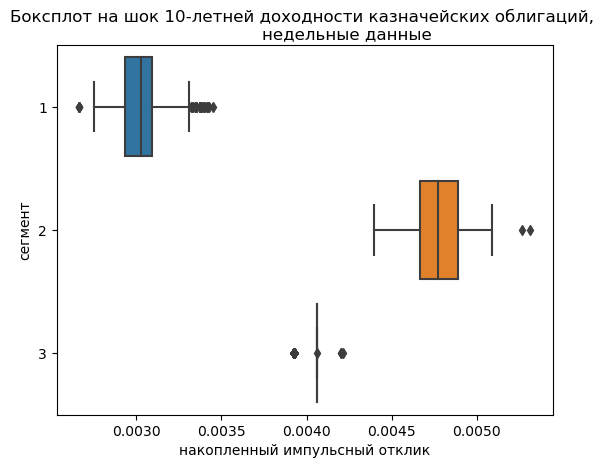

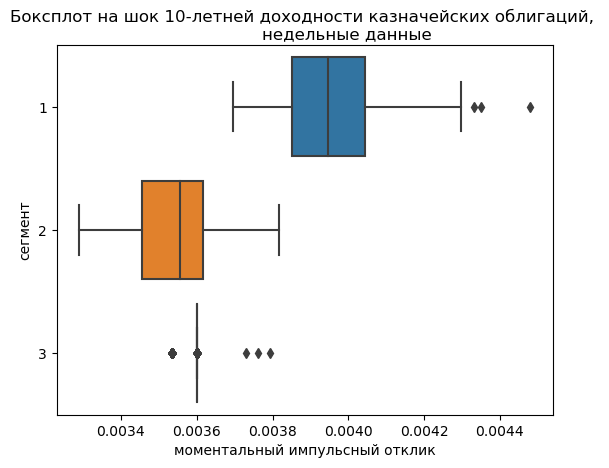

============   DXY, weekly   ============
=======   0   ========
=======   100   ========
=======   200   ========
=======   300   ========
=======   400   ========
=======   500   ========
=======   600   ========
=======   700   ========
=======   800   ========
=======   900   ========
=======   1000   ========


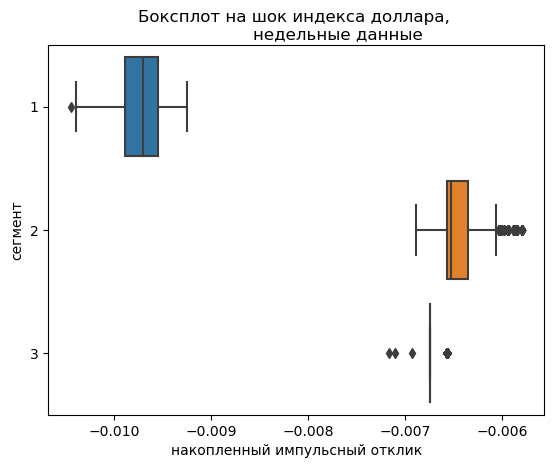

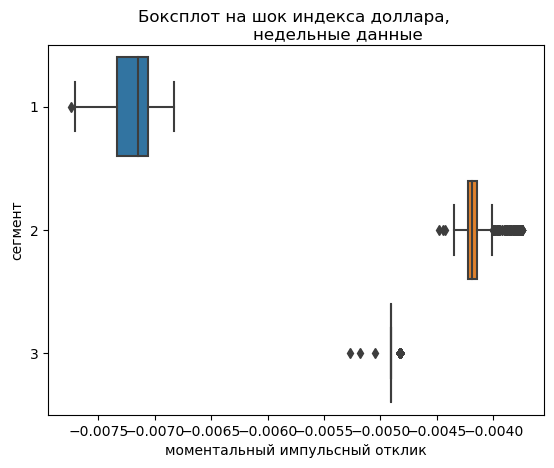

============   SP, weekly   ============
=======   0   ========
=======   100   ========
=======   200   ========
=======   300   ========
=======   400   ========
=======   500   ========
=======   600   ========
=======   700   ========
=======   800   ========
=======   900   ========
=======   1000   ========


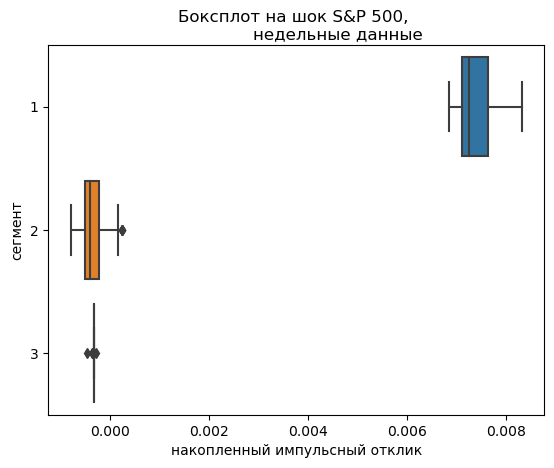

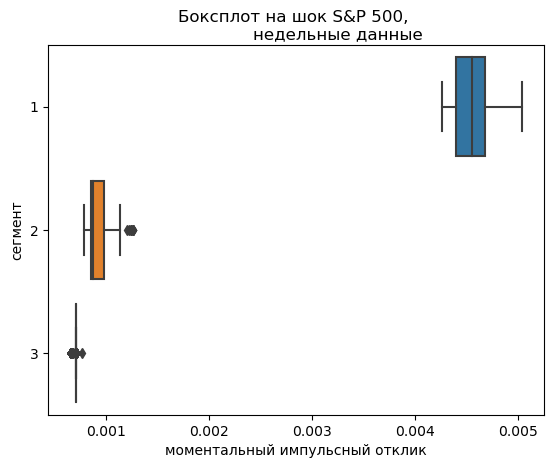

============   VIX, weekly   ============
=======   0   ========
=======   100   ========
=======   200   ========
=======   300   ========
=======   400   ========
=======   500   ========
=======   600   ========
=======   700   ========
=======   800   ========
=======   900   ========
=======   1000   ========


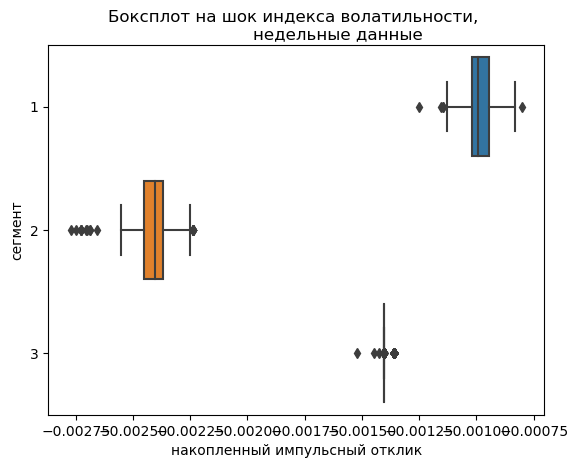

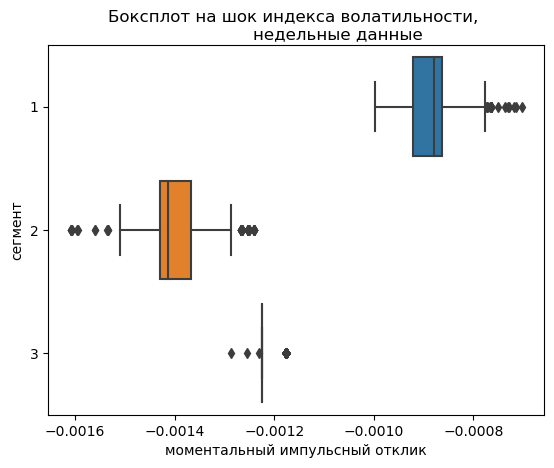

============   10y, daily   ============
=======   0   ========
=======   100   ========
=======   200   ========
=======   300   ========
=======   400   ========
=======   500   ========
=======   600   ========
=======   700   ========
=======   800   ========
=======   900   ========
=======   1000   ========


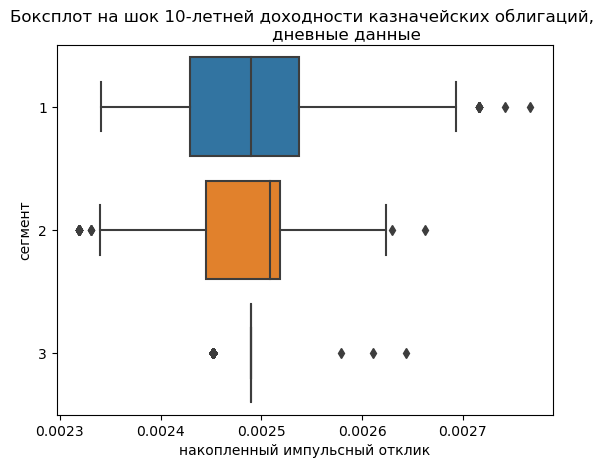

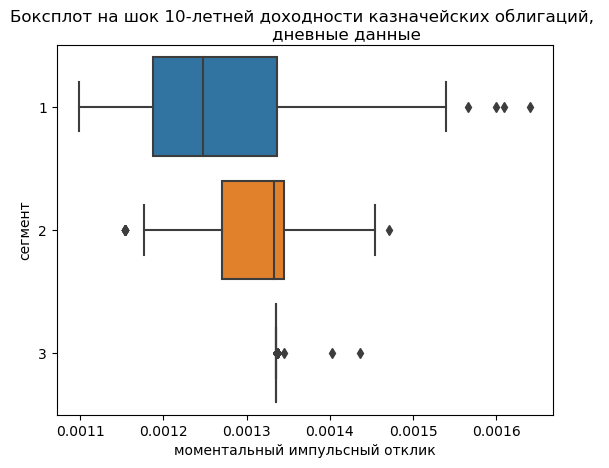

============   DXY, daily   ============
=======   0   ========
=======   100   ========
=======   200   ========
=======   300   ========
=======   400   ========
=======   500   ========
=======   600   ========
=======   700   ========
=======   800   ========
=======   900   ========
=======   1000   ========


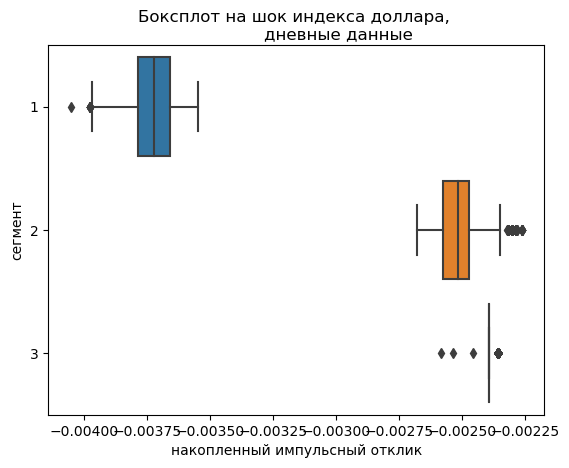

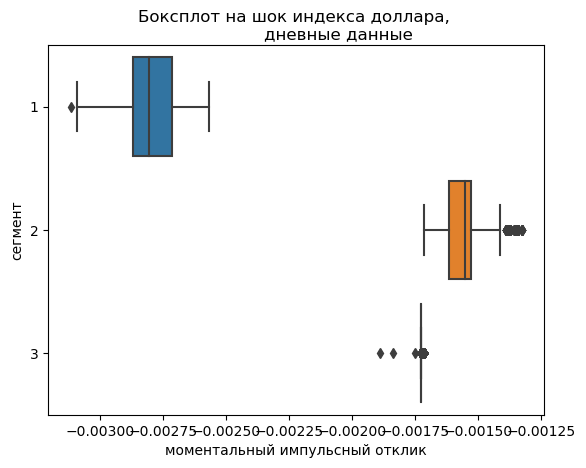

============   SP, daily   ============
=======   0   ========
=======   100   ========
=======   200   ========
=======   300   ========
=======   400   ========
=======   500   ========
=======   600   ========
=======   700   ========
=======   800   ========
=======   900   ========
=======   1000   ========


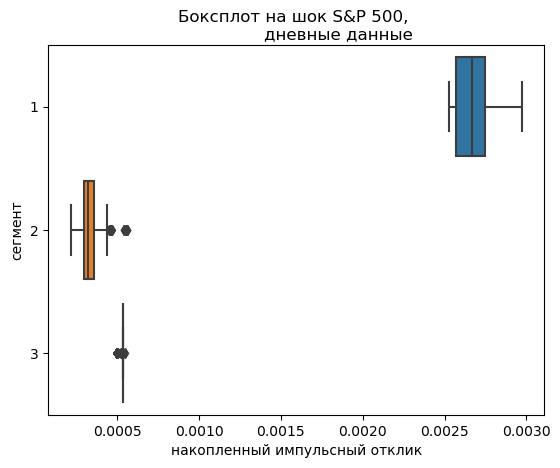

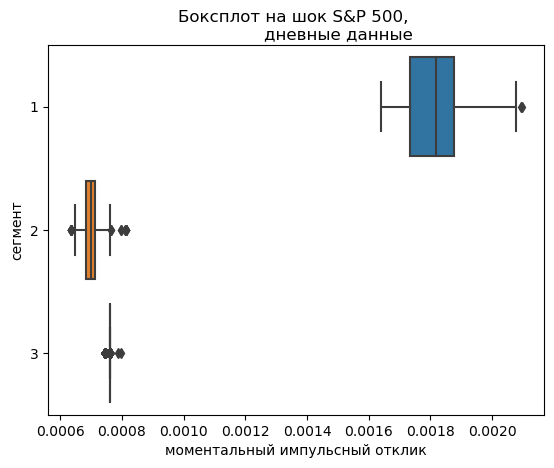

============   VIX, daily   ============
=======   0   ========
=======   100   ========
=======   200   ========
=======   300   ========
=======   400   ========
=======   500   ========
=======   600   ========
=======   700   ========
=======   800   ========
=======   900   ========
=======   1000   ========


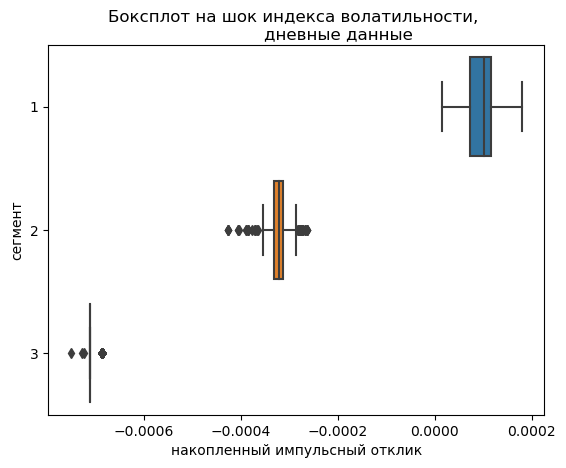

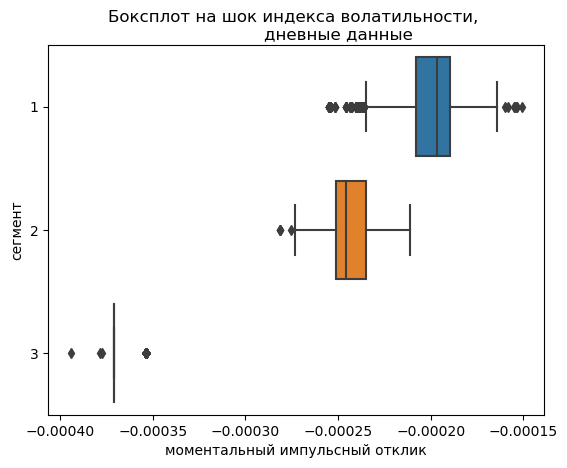

<Figure size 640x480 with 0 Axes>

In [10]:
mean_res = pd.DataFrame(columns = ['cummulative', 'instant', 'impulse', 'freq'])
for fr in frequancy.keys():
    for imp in impulse.keys():
        print(f'============   {imp}, {fr}   ============')
        prop_res = pd.DataFrame(columns = ['period', 'cummulative', 'instant', 'random_state'])
        for r_s in range(1001):
            if r_s % 100 == 0:
                print(f'=======   {r_s}   ========')
            temp_df = IMP_a.query(f"impulse == '{imp}' and freq == '{fr}'").copy()
            x = res_5.query(f'random_state == {r_s}').copy()
            temp_df = temp_df.loc[[temp_df.query(f'period == "{int(x.iloc[i,0])}" and country == "{x.iloc[i,1]}"').index[0] 
                          for i in range(x.shape[0])], :].copy()
            temp_df.loc[:, 'cluster'] = [x.query(f'period == "{int(temp_df.iloc[i,2])}" and country == "{temp_df.iloc[i,3]}"') \
                                         .iloc[0, 2] for i in range(temp_df.shape[0])]
            temp_df = temp_df.groupby(['period', 'cluster']) \
                            .agg({'cummulative': 'mean', 'instant': 'mean', 'ci':'count'}).reset_index()
            temp_df.loc[:, ['cummulative', 'instant']] = \
                            temp_df.loc[:, ['cummulative', 'instant']] * temp_df.loc[:, ['ci']].to_numpy() / temp_df.shape[0]/3
            temp_df = temp_df.groupby('period').agg({'cummulative':'sum', 'instant':'sum'}).reset_index()
            temp_df.loc[:, 'random_state'] = r_s
            prop_res = pd.concat([prop_res, temp_df])
        
        
        
        ax = sns.boxplot(x = prop_res['cummulative'],y =  prop_res['period'])
        fig_name = f'''Боксплот на шок {impulse[imp]}, 
                {frequancy[fr]}'''
        ax.set_title(fig_name, wrap = True)
        ax.set(xlabel='накопленный импульсный отклик', ylabel='сегмент')
        plt.savefig(f'C:/Users/vasil/YandexDisk/D is not for Dragons/plots & tables/new_ortho/{imp + "_" + fr + "_c"}.jpeg')
        plt.show()
        
        plt.clf()
        
        ax = sns.boxplot(x = prop_res['instant'],y =  prop_res['period'])
        fig_name = f'''Боксплот на шок {impulse[imp]}, 
                {frequancy[fr]}'''
        ax.set_title(fig_name, wrap = True)
        ax.set(xlabel='моментальный импульсный отклик', ylabel='сегмент')
        plt.savefig(f'C:/Users/vasil/YandexDisk/D is not for Dragons/plots & tables/new_ortho/{imp + "_" + fr + "_i"}.jpeg')
        plt.show()
        
        plt.clf()
        
        prop_res = prop_res.groupby('period').agg({'cummulative':'mean', 'instant':'mean'})
        prop_res.loc[:, ['impulse', 'freq']] = [imp, fr]
        mean_res = pd.concat([mean_res, prop_res])

[Text(0.5, 0, 'финансовая открытость'),
 Text(0, 0.5, 'накопленный импульсный отклик на VIX')]

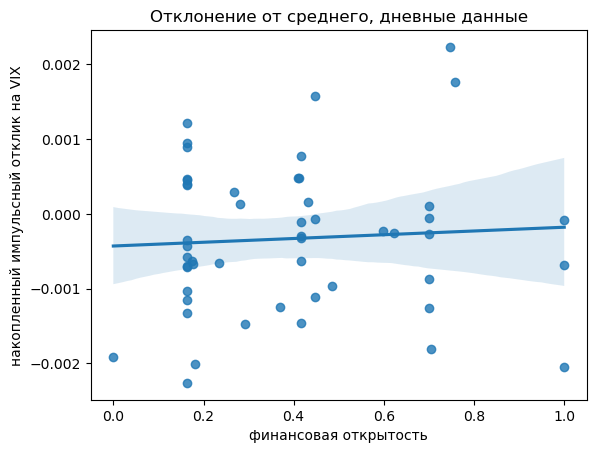

In [14]:
scatter = IMP_a.query("freq == 'daily' and impulse == 'VIX'").loc[:, ['cummulative', 'fo', 'period']]
scatter.loc[:, 'cummulative'] = [i - mean_res.query("freq == 'daily' and impulse == 'VIX'").loc[j,'cummulative'] 
                                 for i,j in zip(scatter.cummulative, scatter.period)]
ax = sns.regplot(data=scatter, x="fo", y="cummulative")
ax.set_title('Отклонение от среднего, дневные данные', wrap = True)
ax.set(xlabel='финансовая открытость', ylabel='накопленный импульсный отклик на VIX')

[Text(0.5, 0, 'финансовая открытость'),
 Text(0, 0.5, 'накопленный импульсный отклик на VIX')]

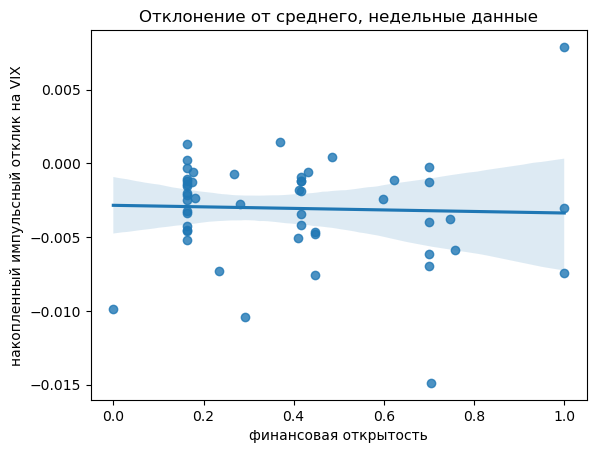

In [15]:
scatter = IMP_a.query("freq == 'weekly' and impulse == 'VIX'").loc[:, ['cummulative', 'fo', 'period']]
scatter.loc[:, 'cummulative'] = [i - mean_res.query("freq == 'daily' and impulse == 'VIX'").loc[j,'cummulative'] 
                                 for i,j in zip(scatter.cummulative, scatter.period)]
ax = sns.regplot(data=scatter, x="fo", y="cummulative")
ax.set_title('Отклонение от среднего, недельные данные', wrap = True)
ax.set(xlabel='финансовая открытость', ylabel='накопленный импульсный отклик на VIX')

Text(0.5, 0.98, 'India and India domestic')

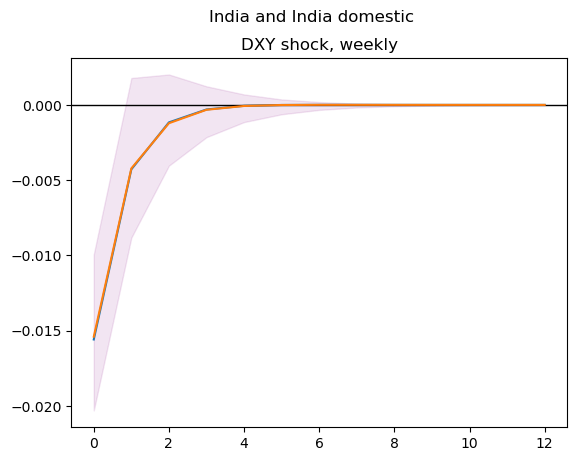

In [13]:
IND_SP = data_imp.query(f'country == "INDIA" and freq == "weekly" and period == "1" and impulse == "DXY"')
y = IND_SP.query("ci == 'irf'").iloc[:, :13].to_numpy().ravel()
ci1 = IND_SP.query("ci == 'Lower'").iloc[:, :13].to_numpy().ravel()
ci2 = IND_SP.query("ci == 'Upper'").iloc[:, :13].to_numpy().ravel()

INDD_SP = data_imp.query(f'country == "INDIA.DOMESTIC" and freq == "weekly" and period == "1" and impulse == "DXY"')
yd = INDD_SP.query("ci == 'irf'").iloc[:, :13].to_numpy().ravel()
ci1d = INDD_SP.query("ci == 'Lower'").iloc[:, :13].to_numpy().ravel()
ci2d = INDD_SP.query("ci == 'Upper'").iloc[:, :13].to_numpy().ravel()

fig, ax = plt.subplots()
ax.plot(range(13), y)
ax.fill_between(range(13), ci1, ci2, color='b', alpha=.05)
ax.axline((0,0), (12,0), linewidth = 1, color = 'black')
ax.plot(range(13), yd)
ax.fill_between(range(13), ci1, ci2, color='r', alpha=.05)

ax.set_title('DXY shock, weekly')
fig.suptitle('India and India domestic')

C:\Users\vasil\AppData\Local\Temp\ipykernel_5776\2231986639.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure, axis = plt.subplots(6, 3, figsize=(10, 18))


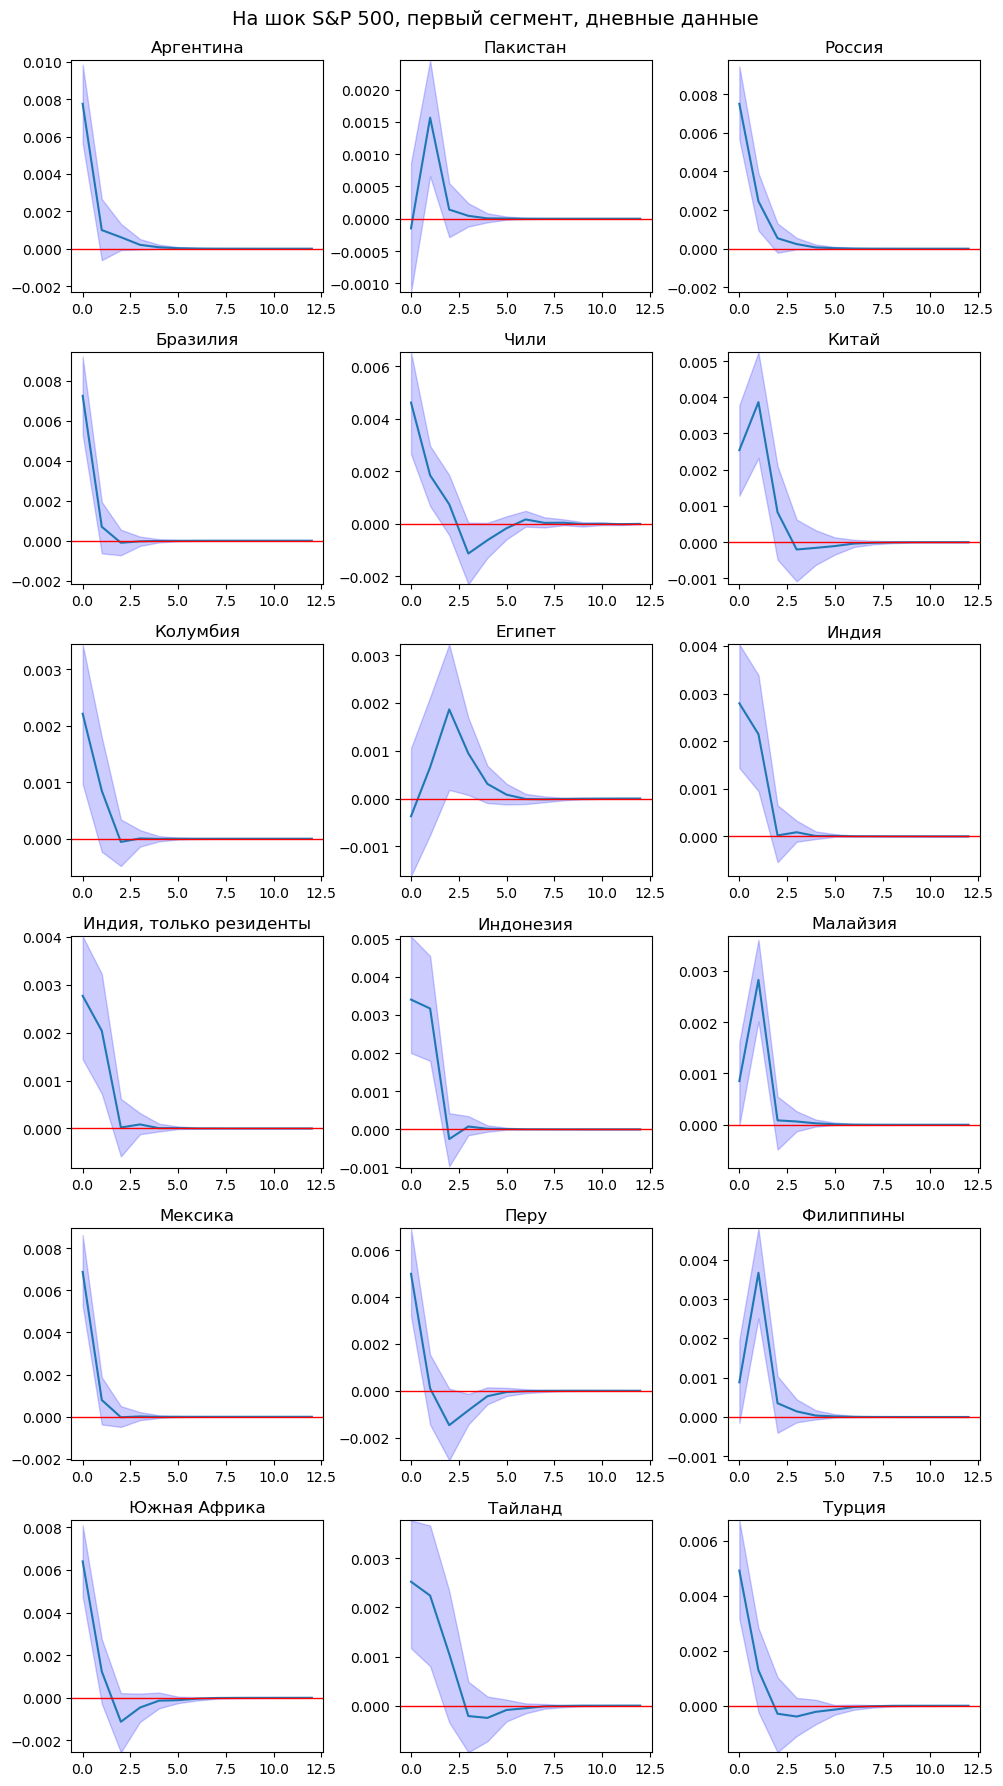

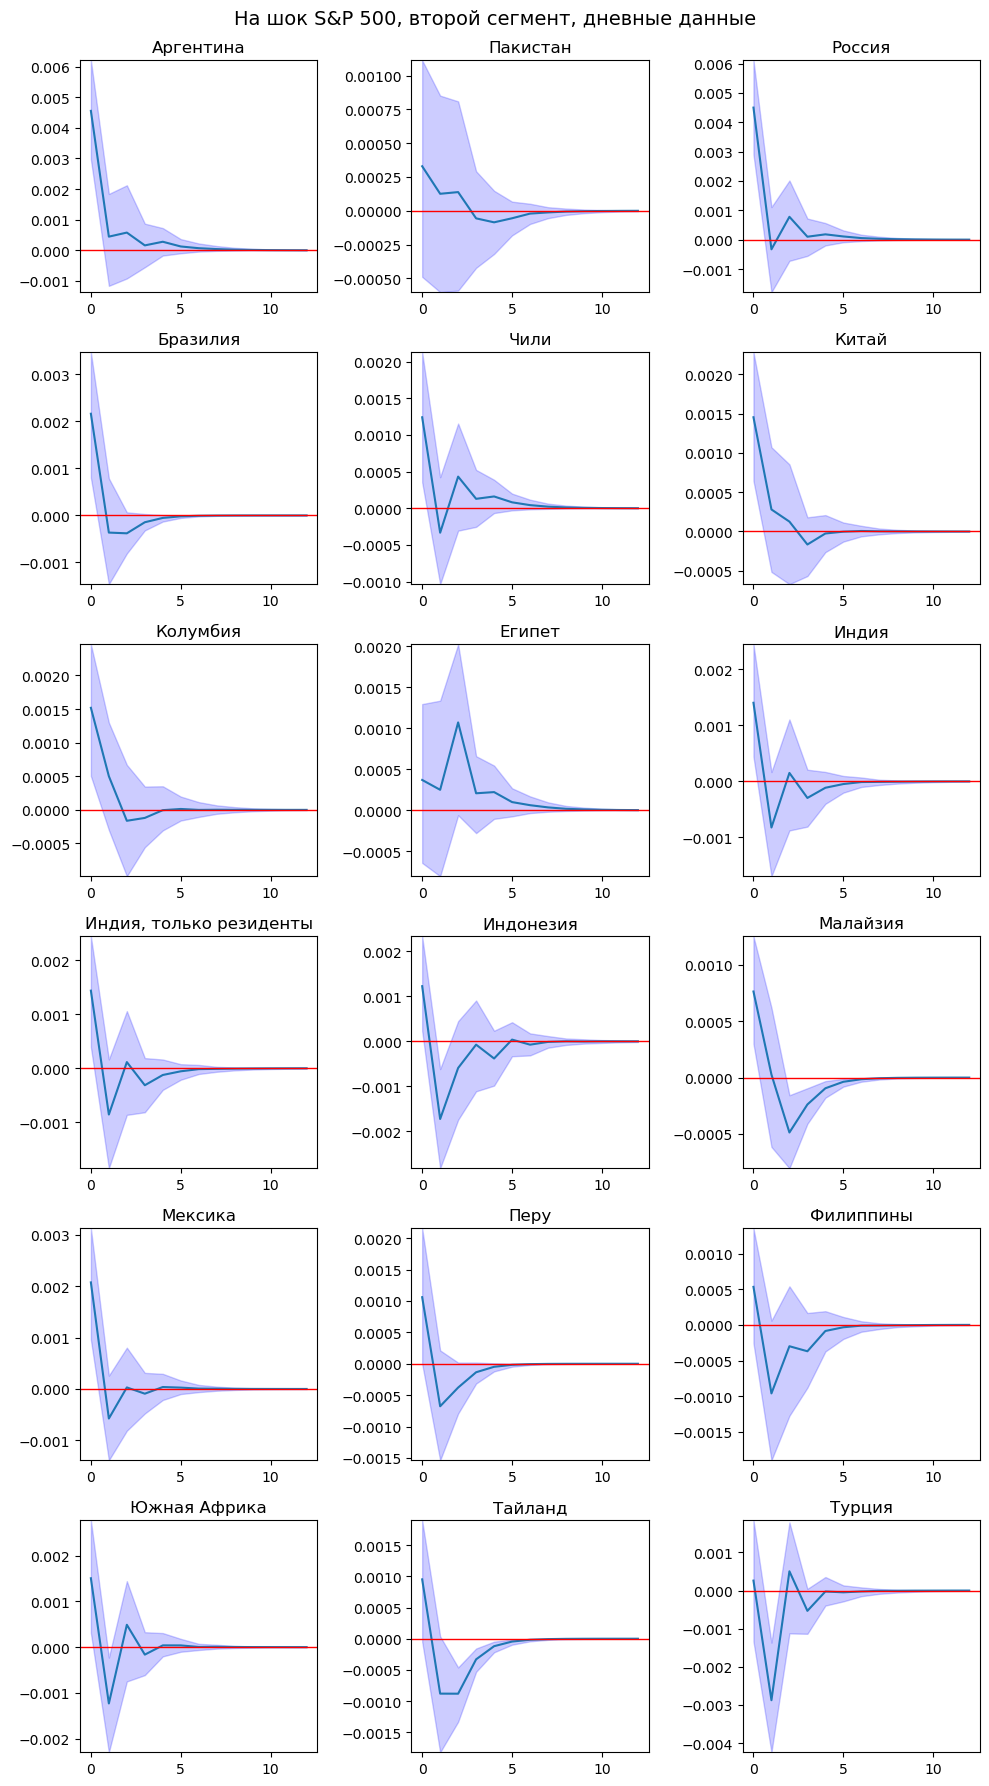

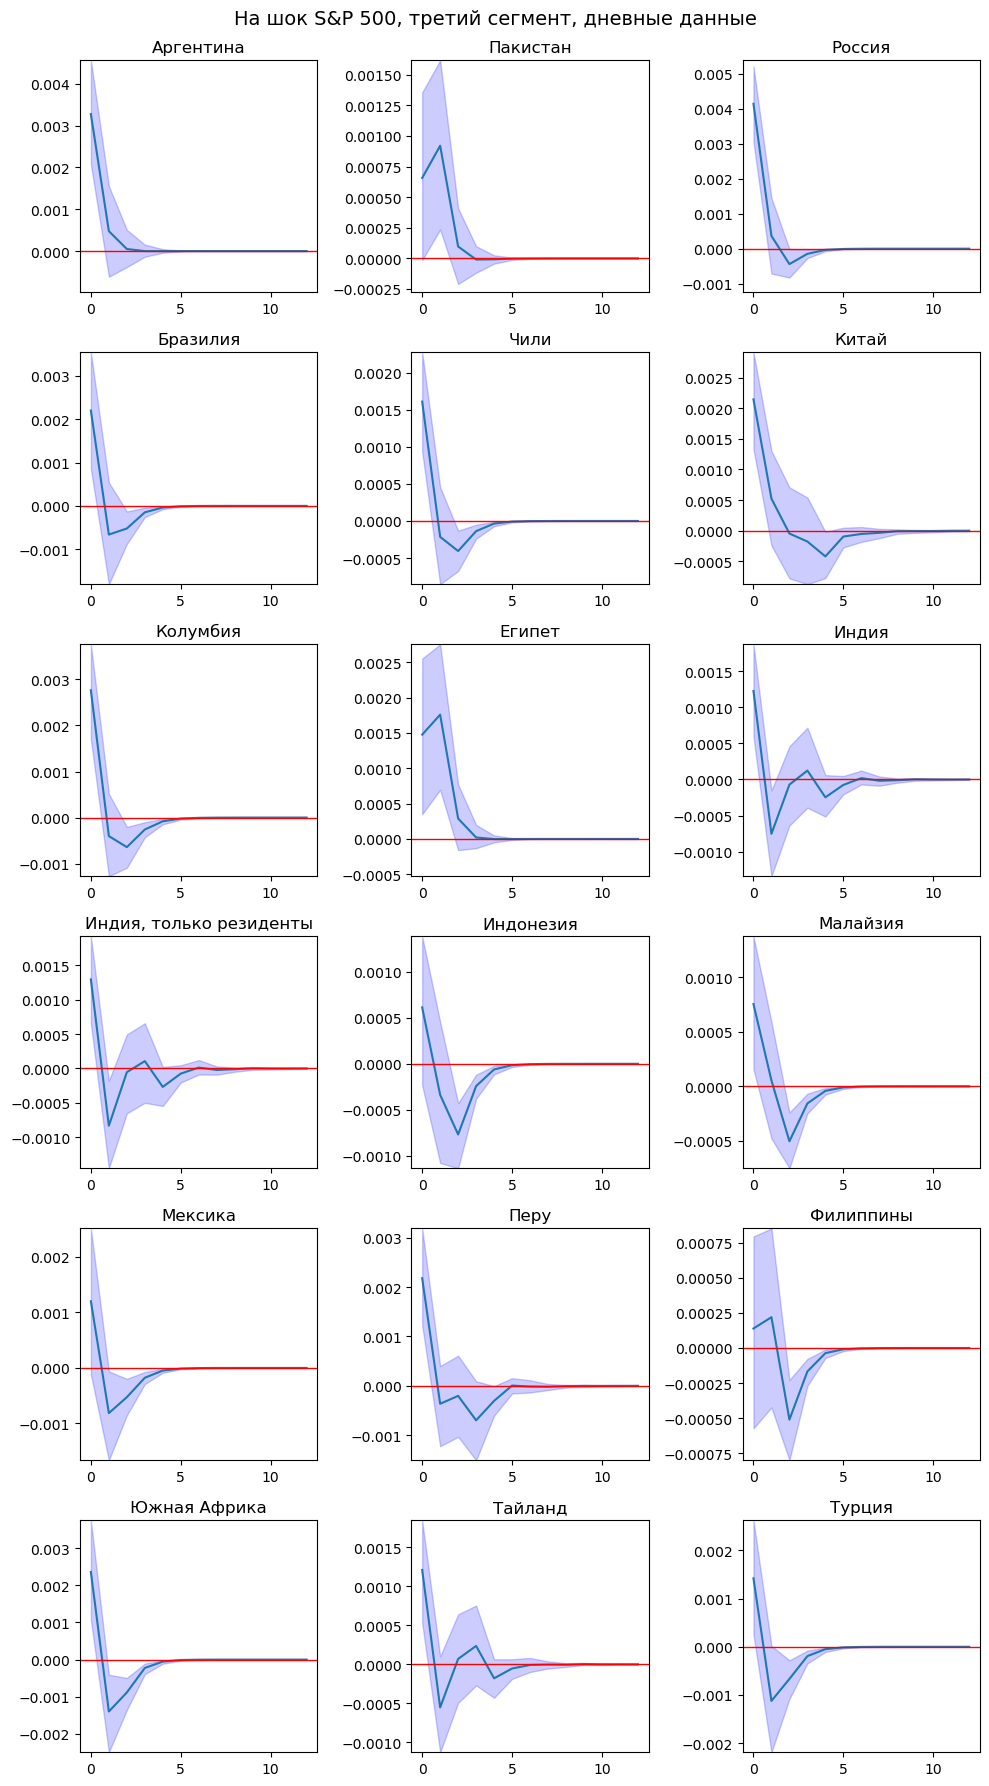

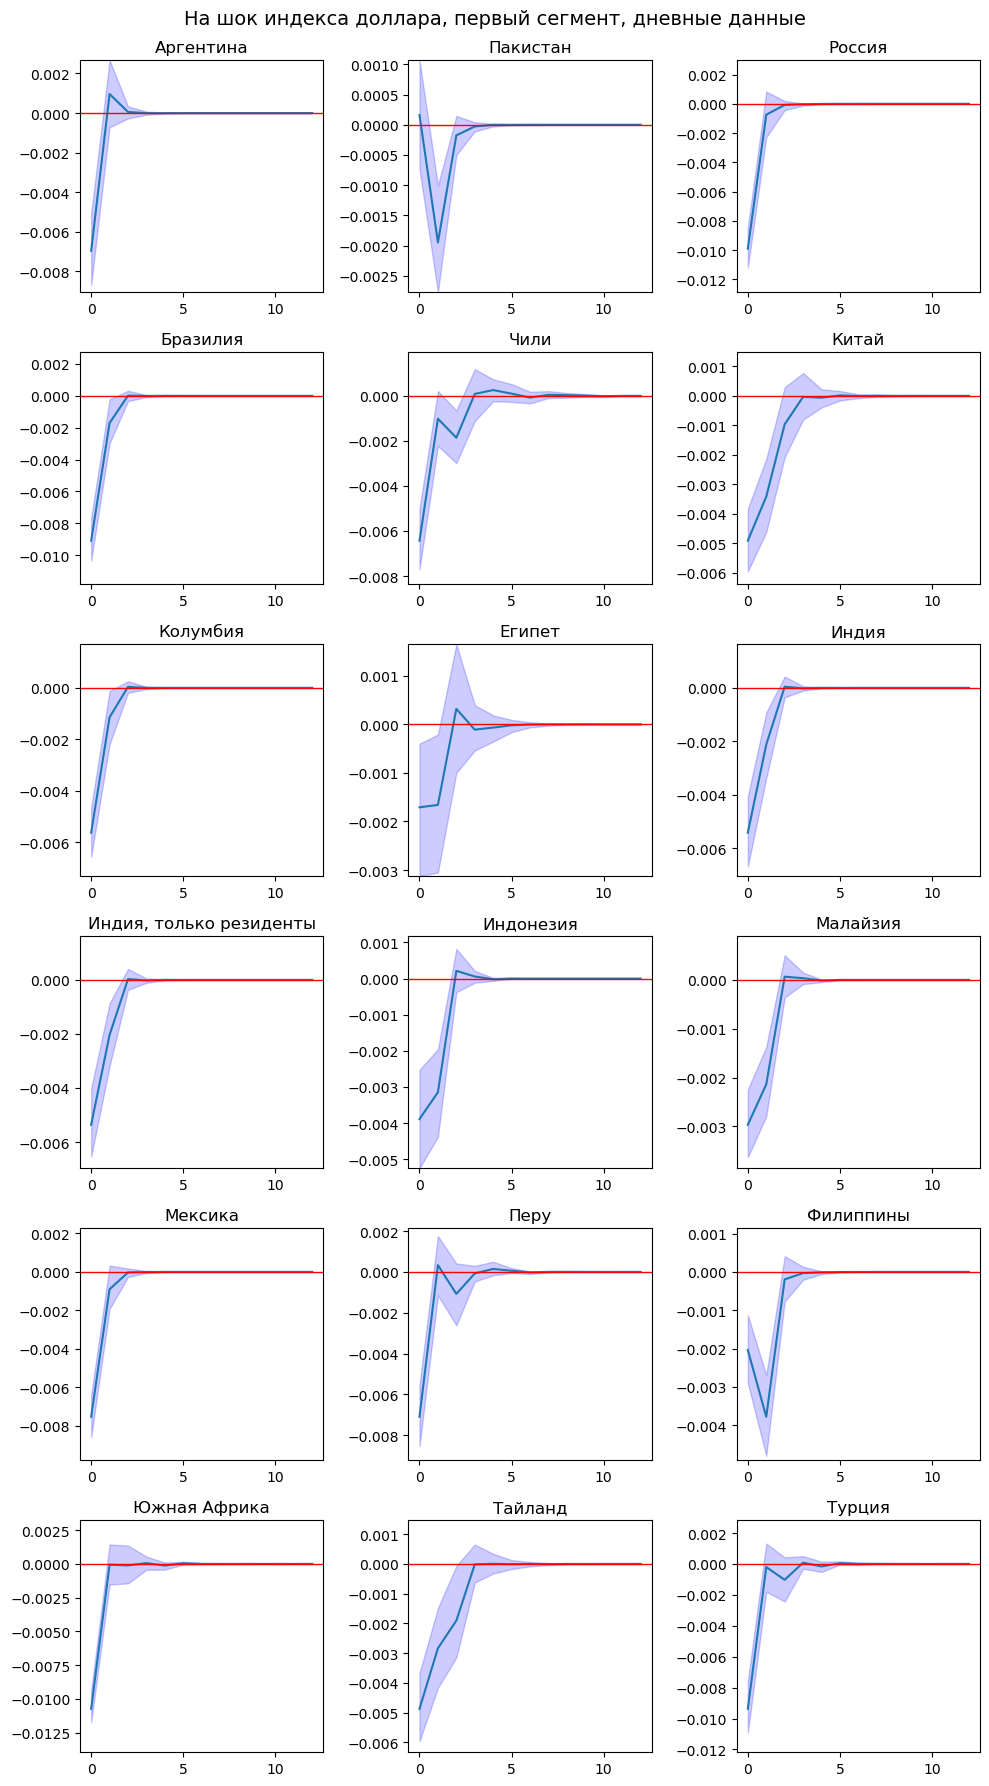

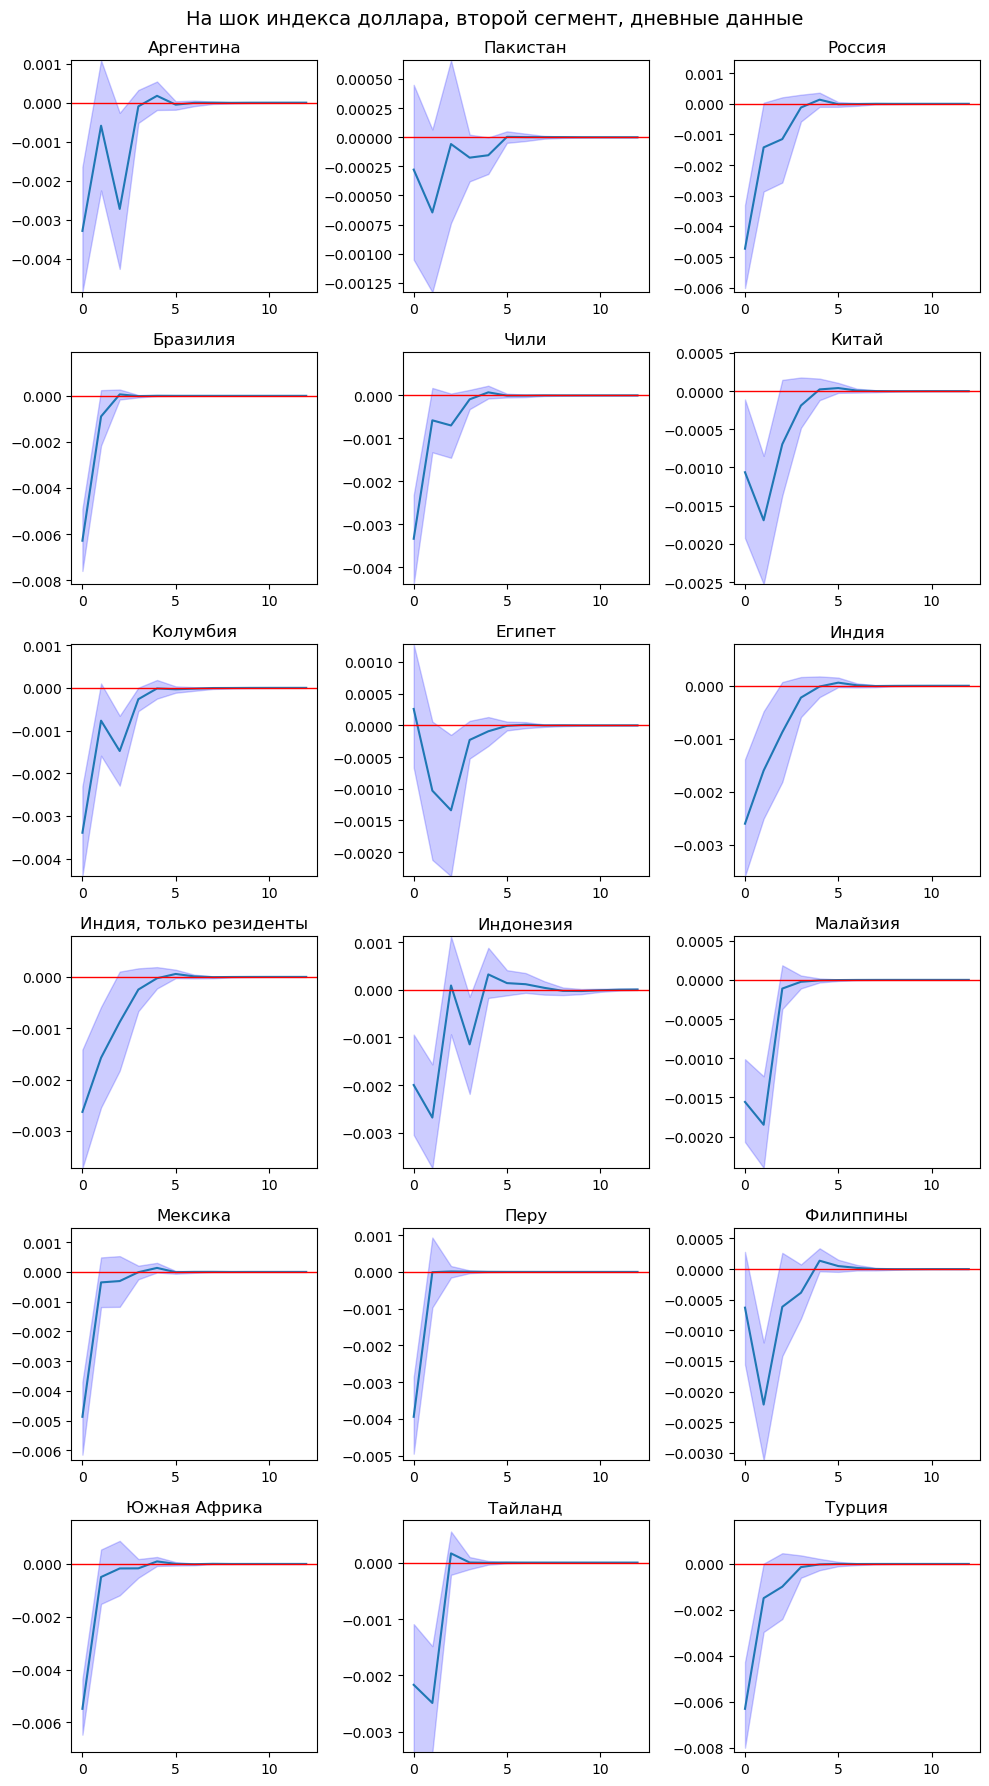

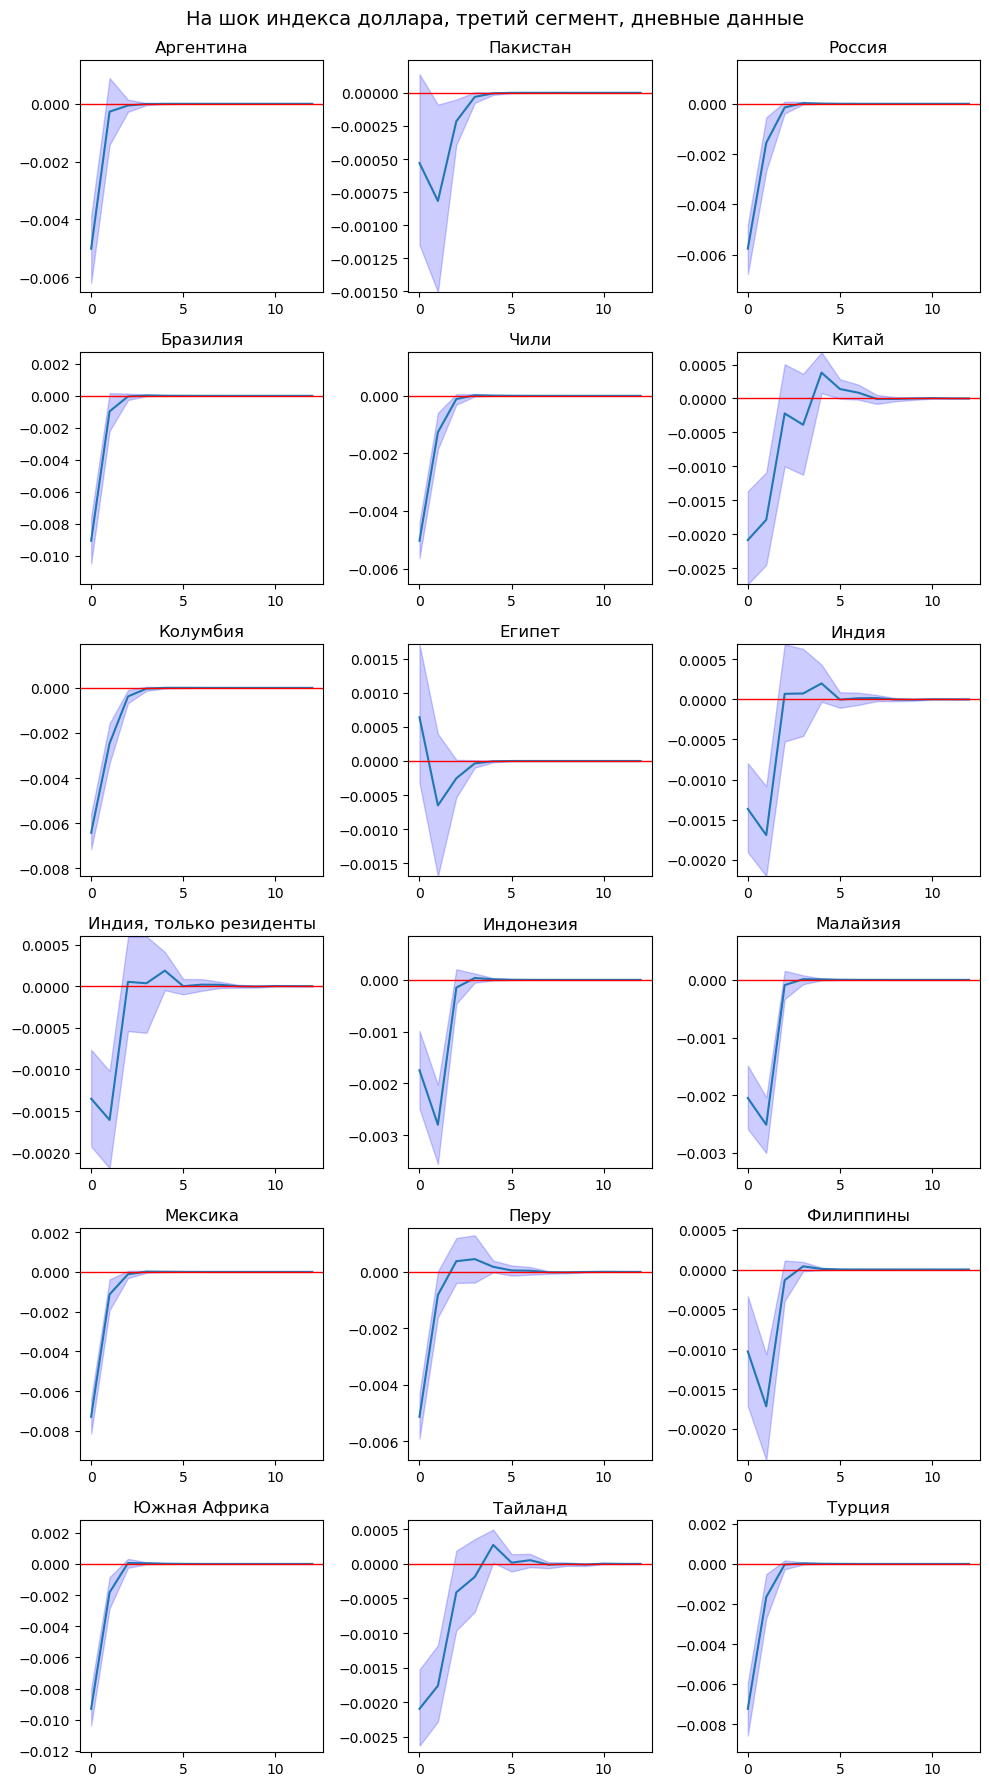

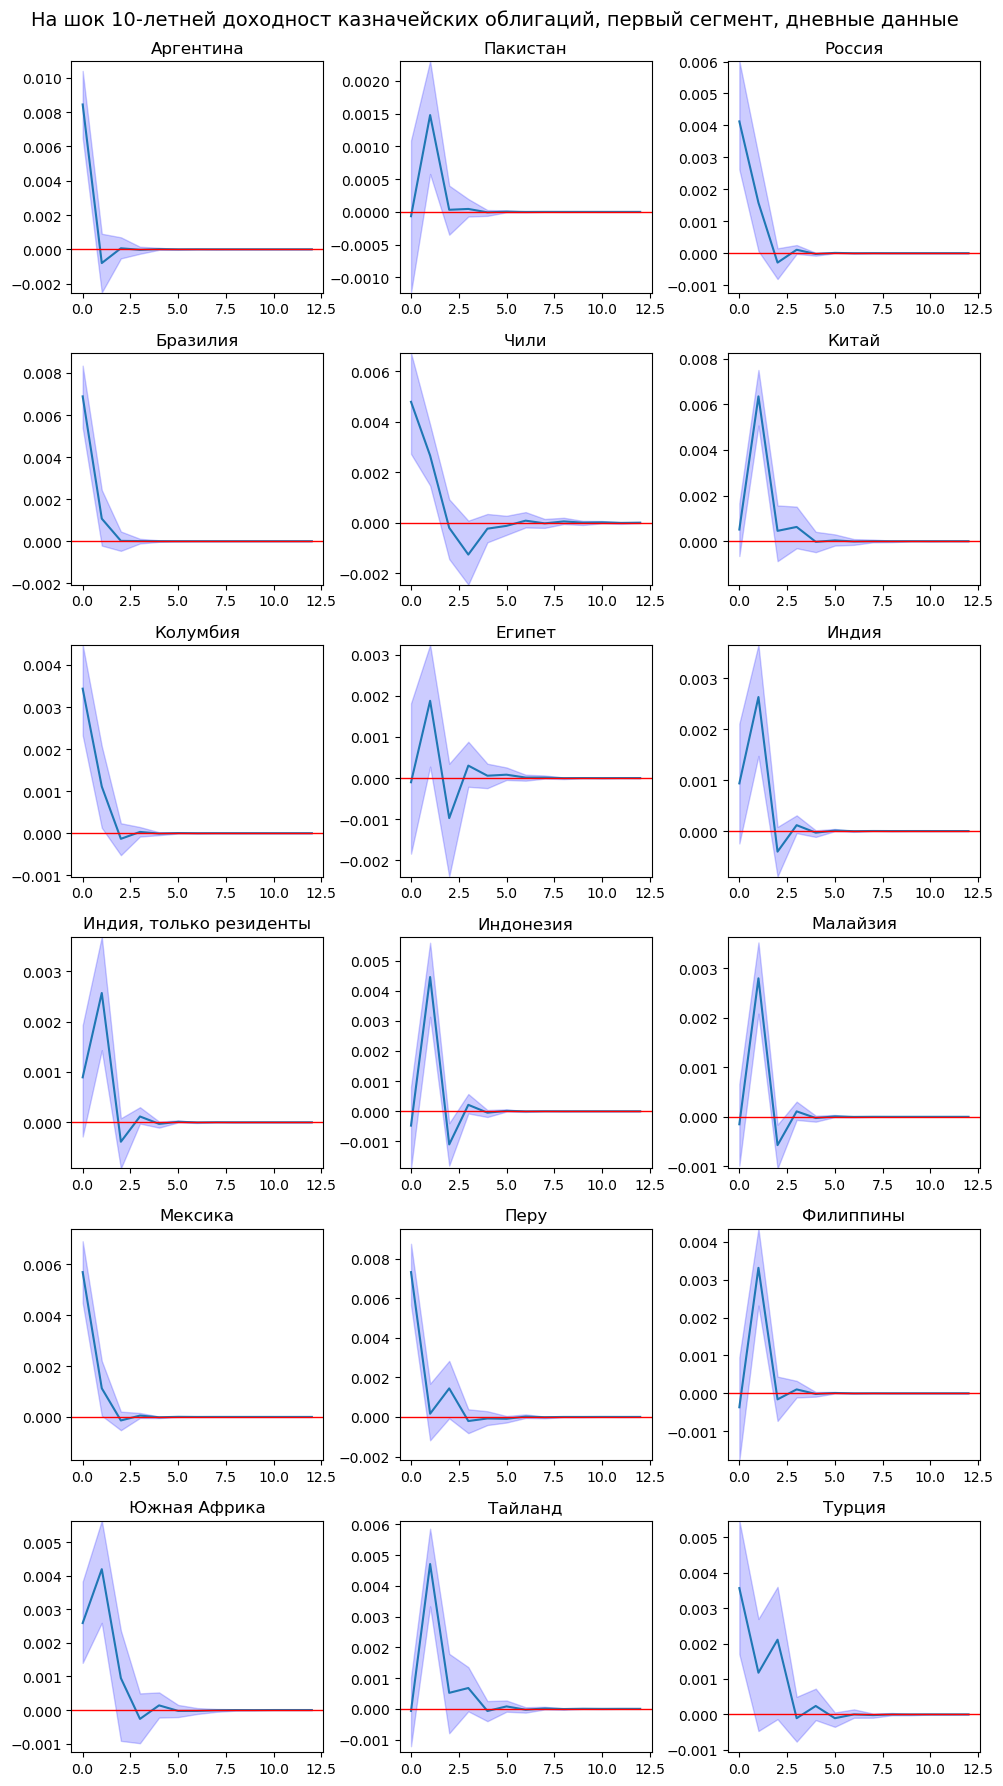

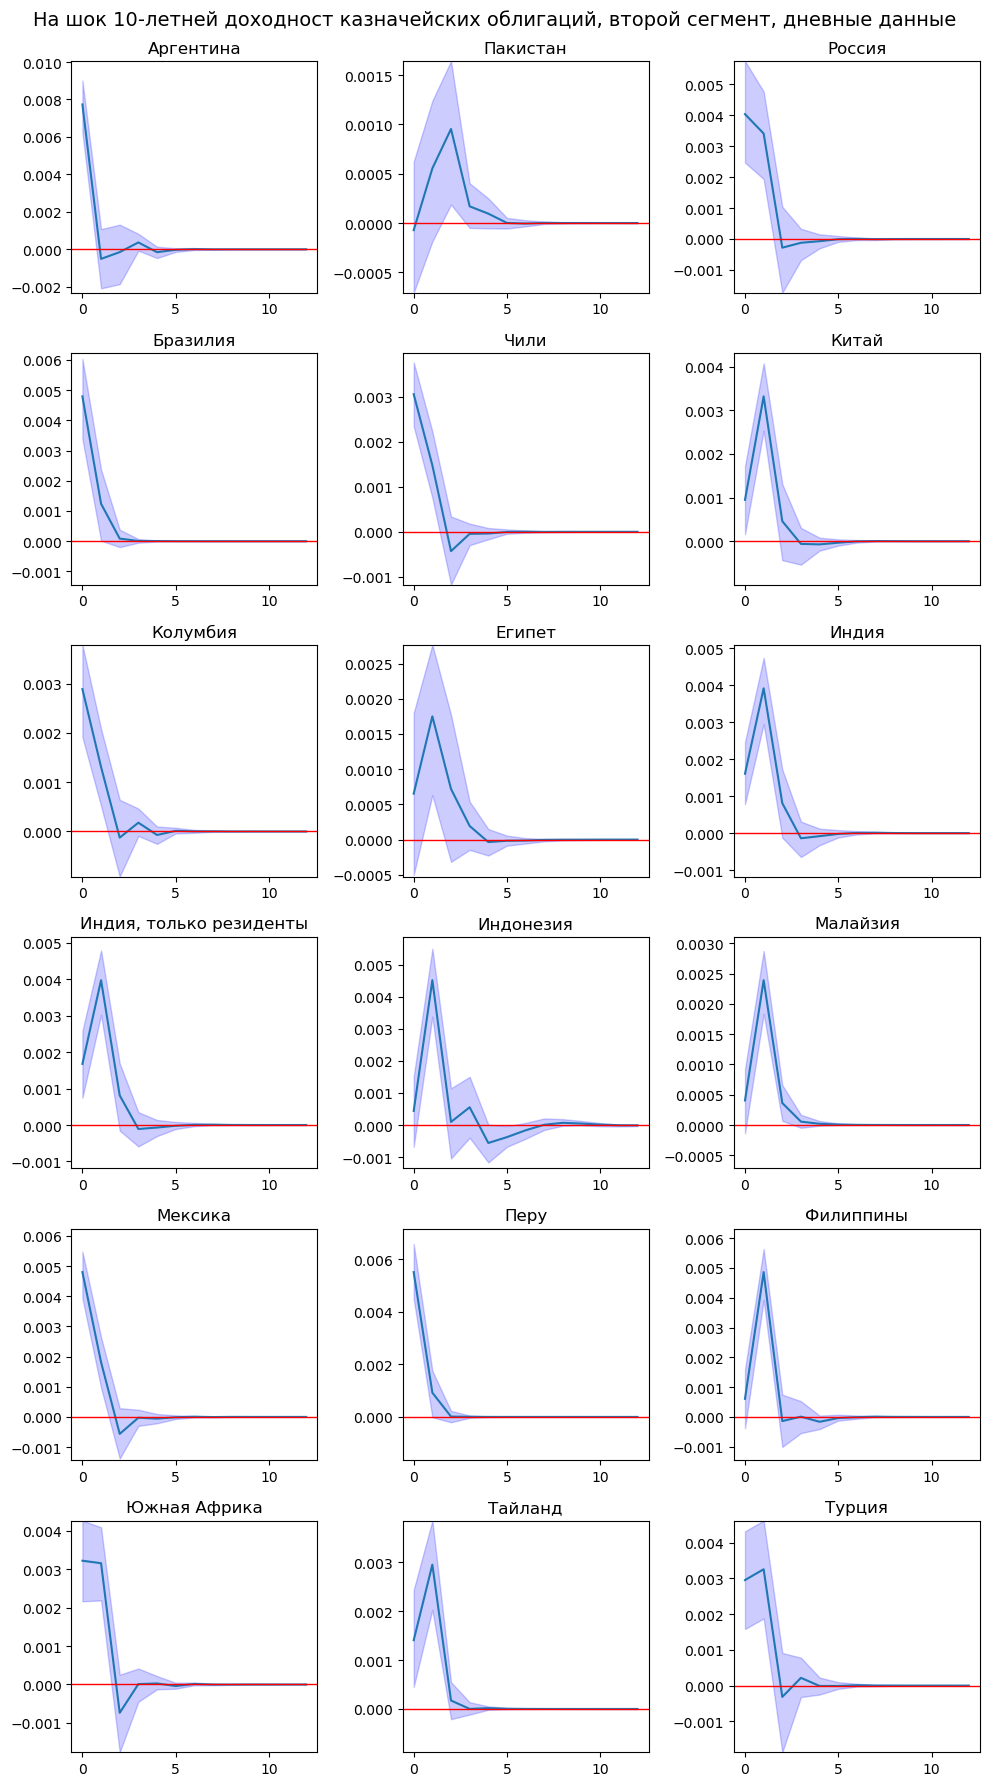

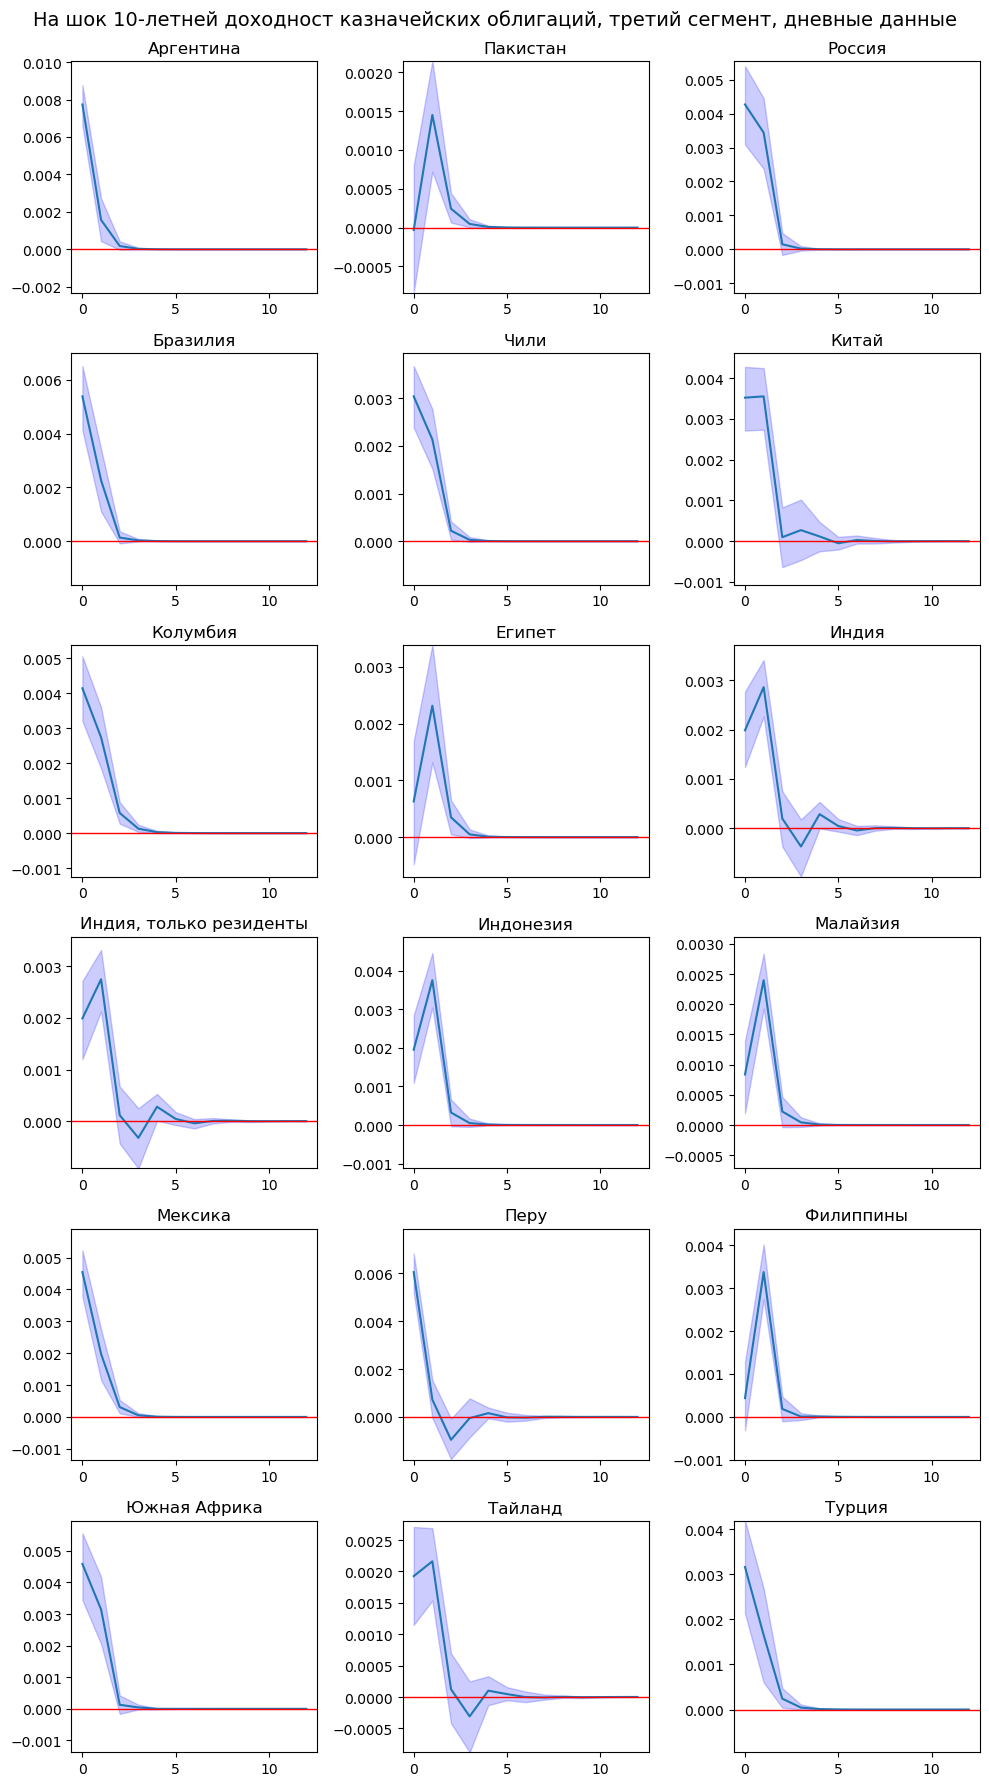

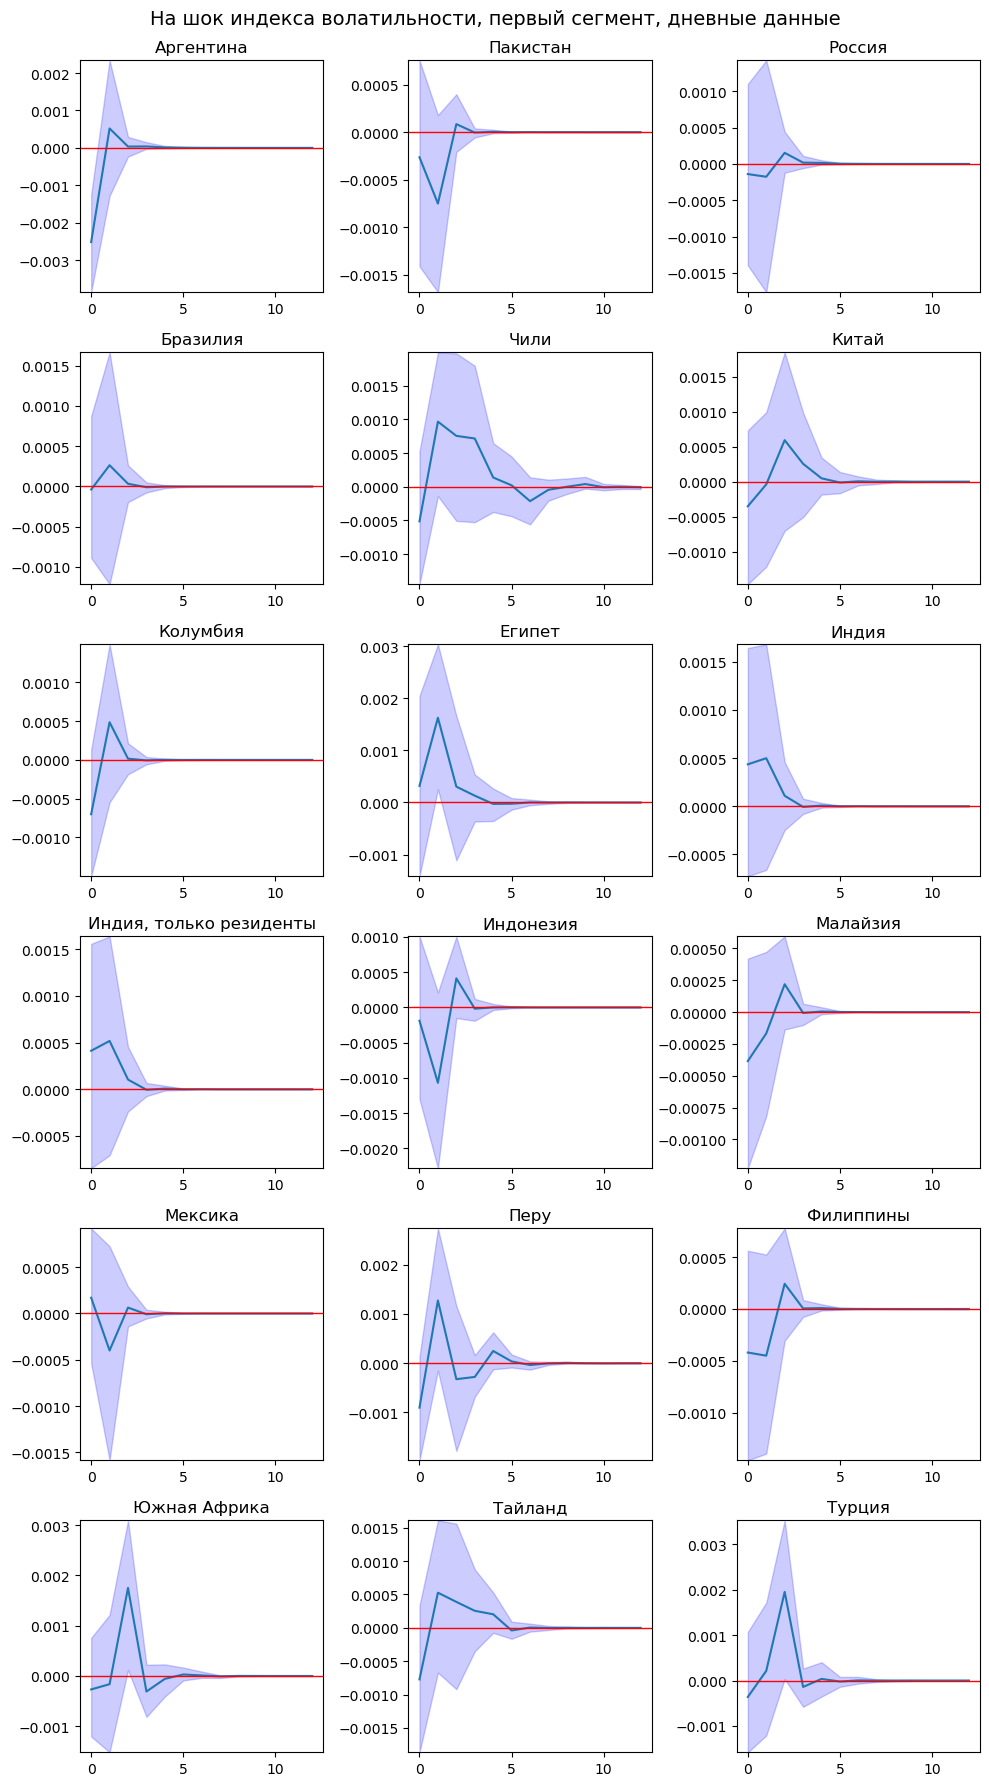

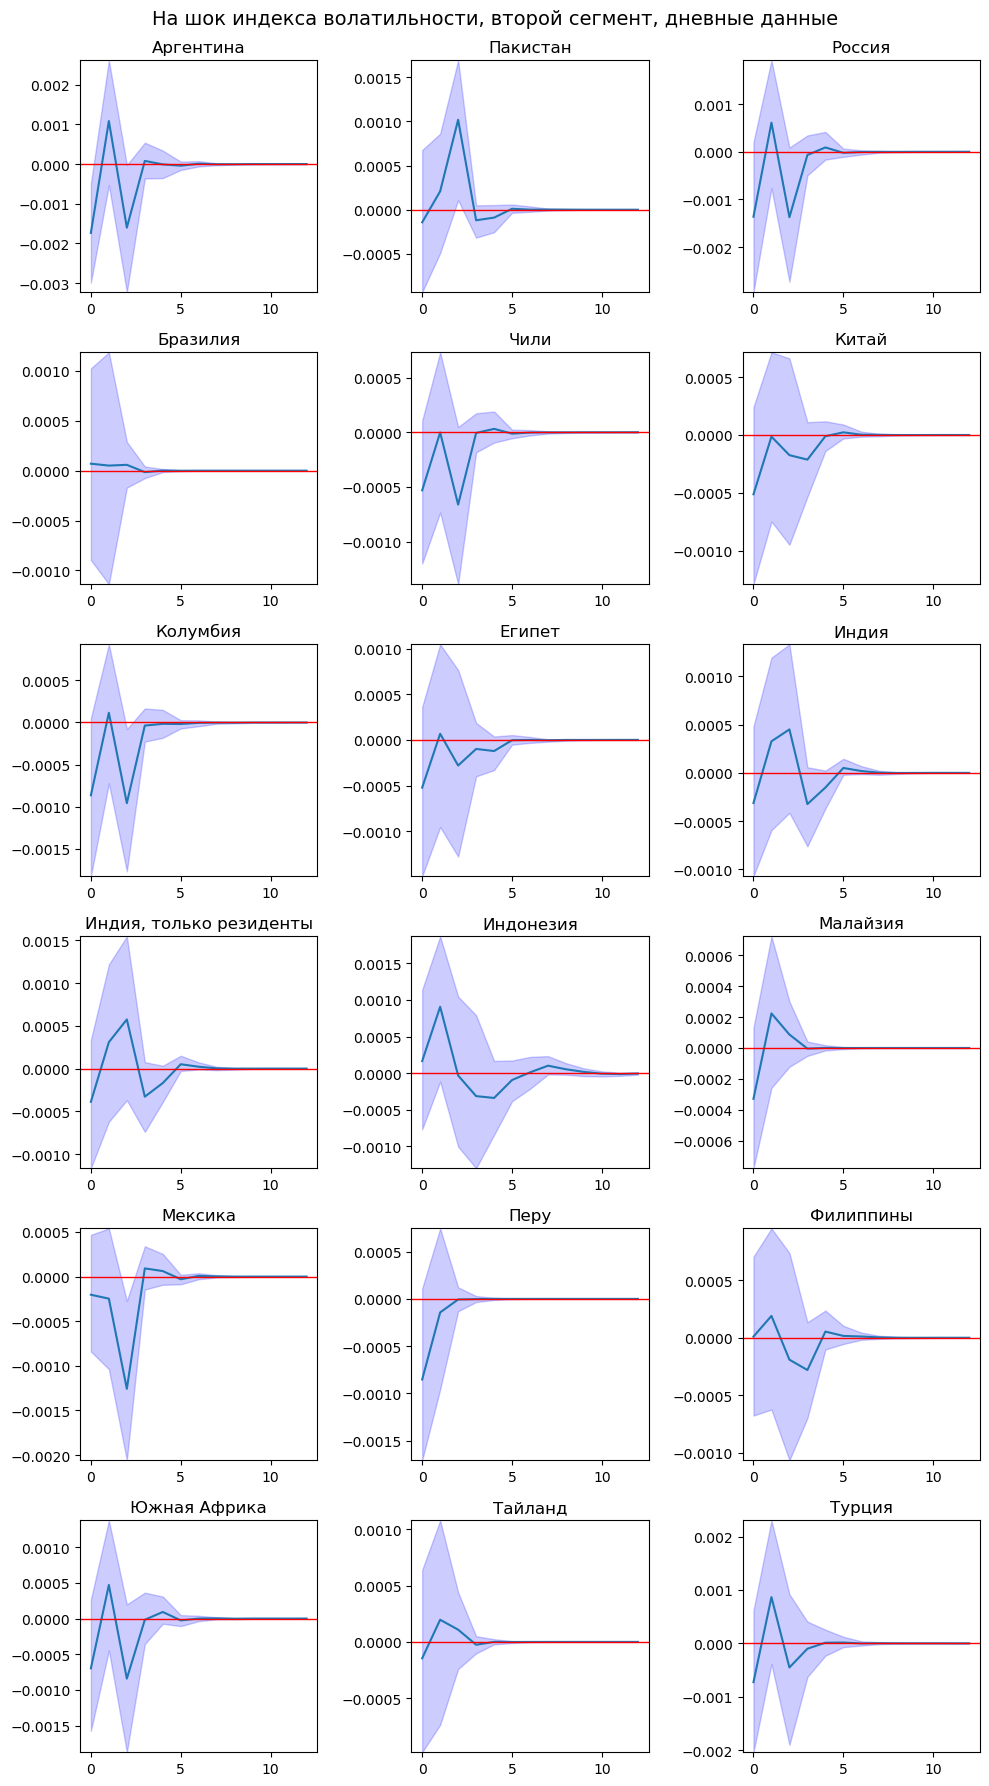

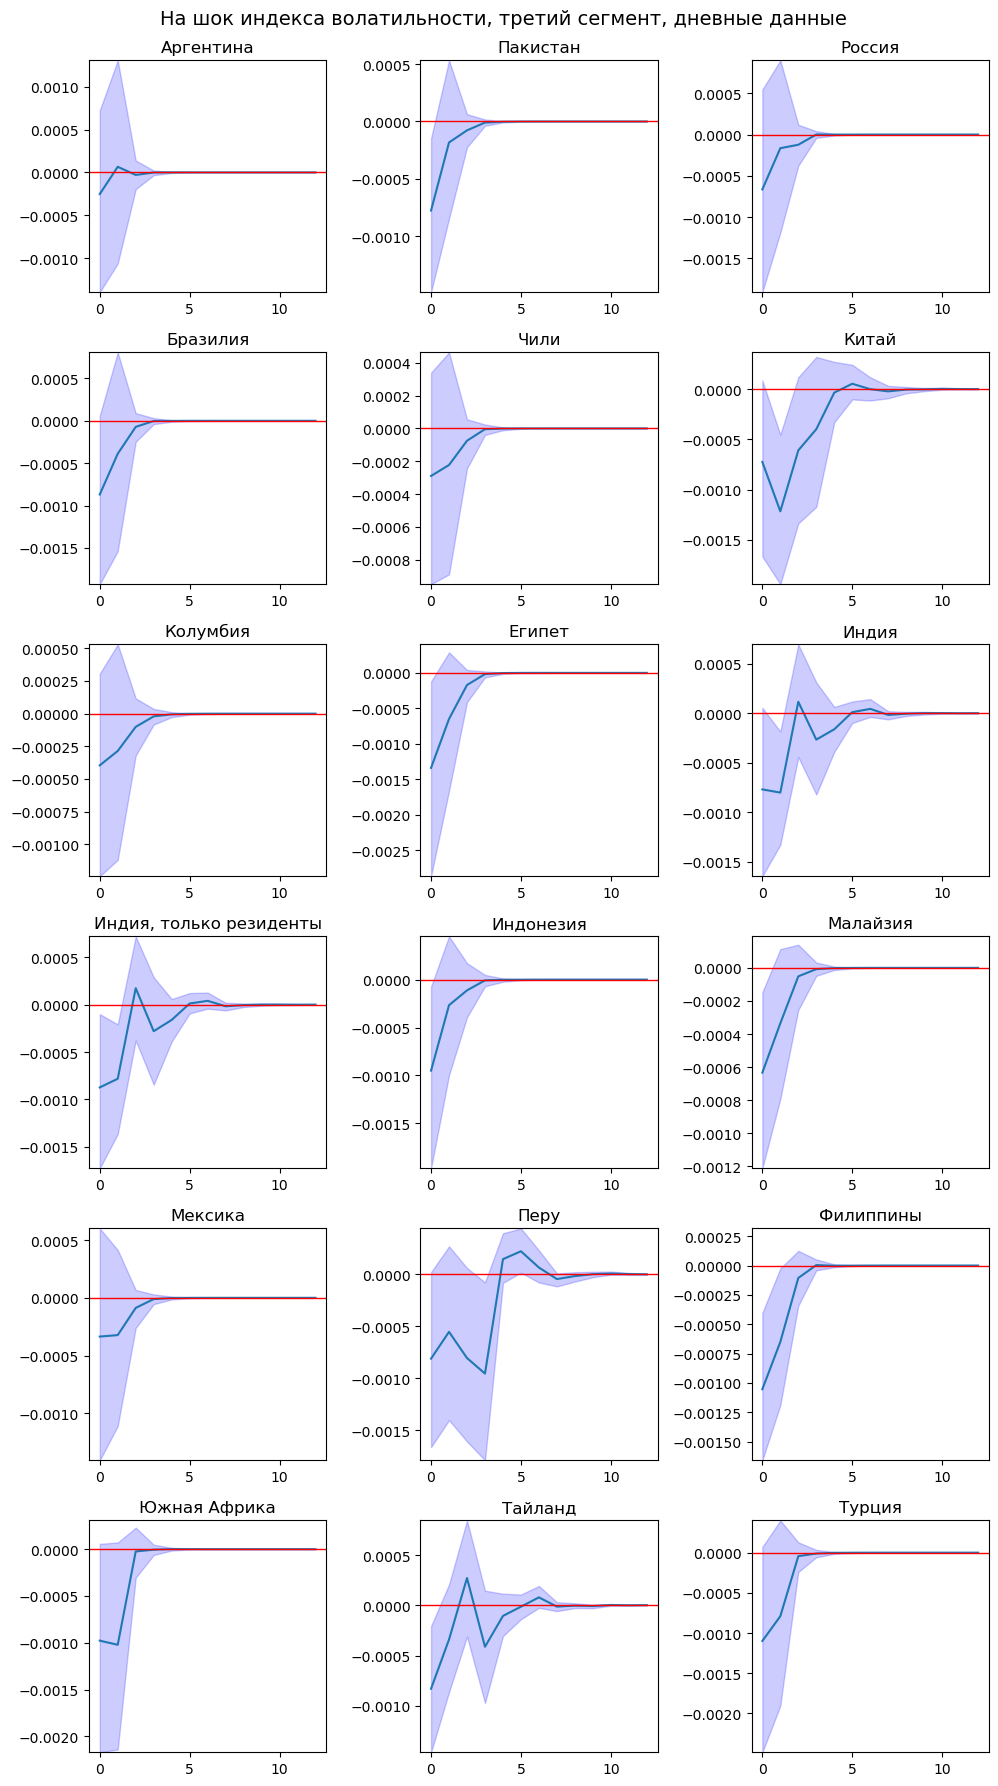

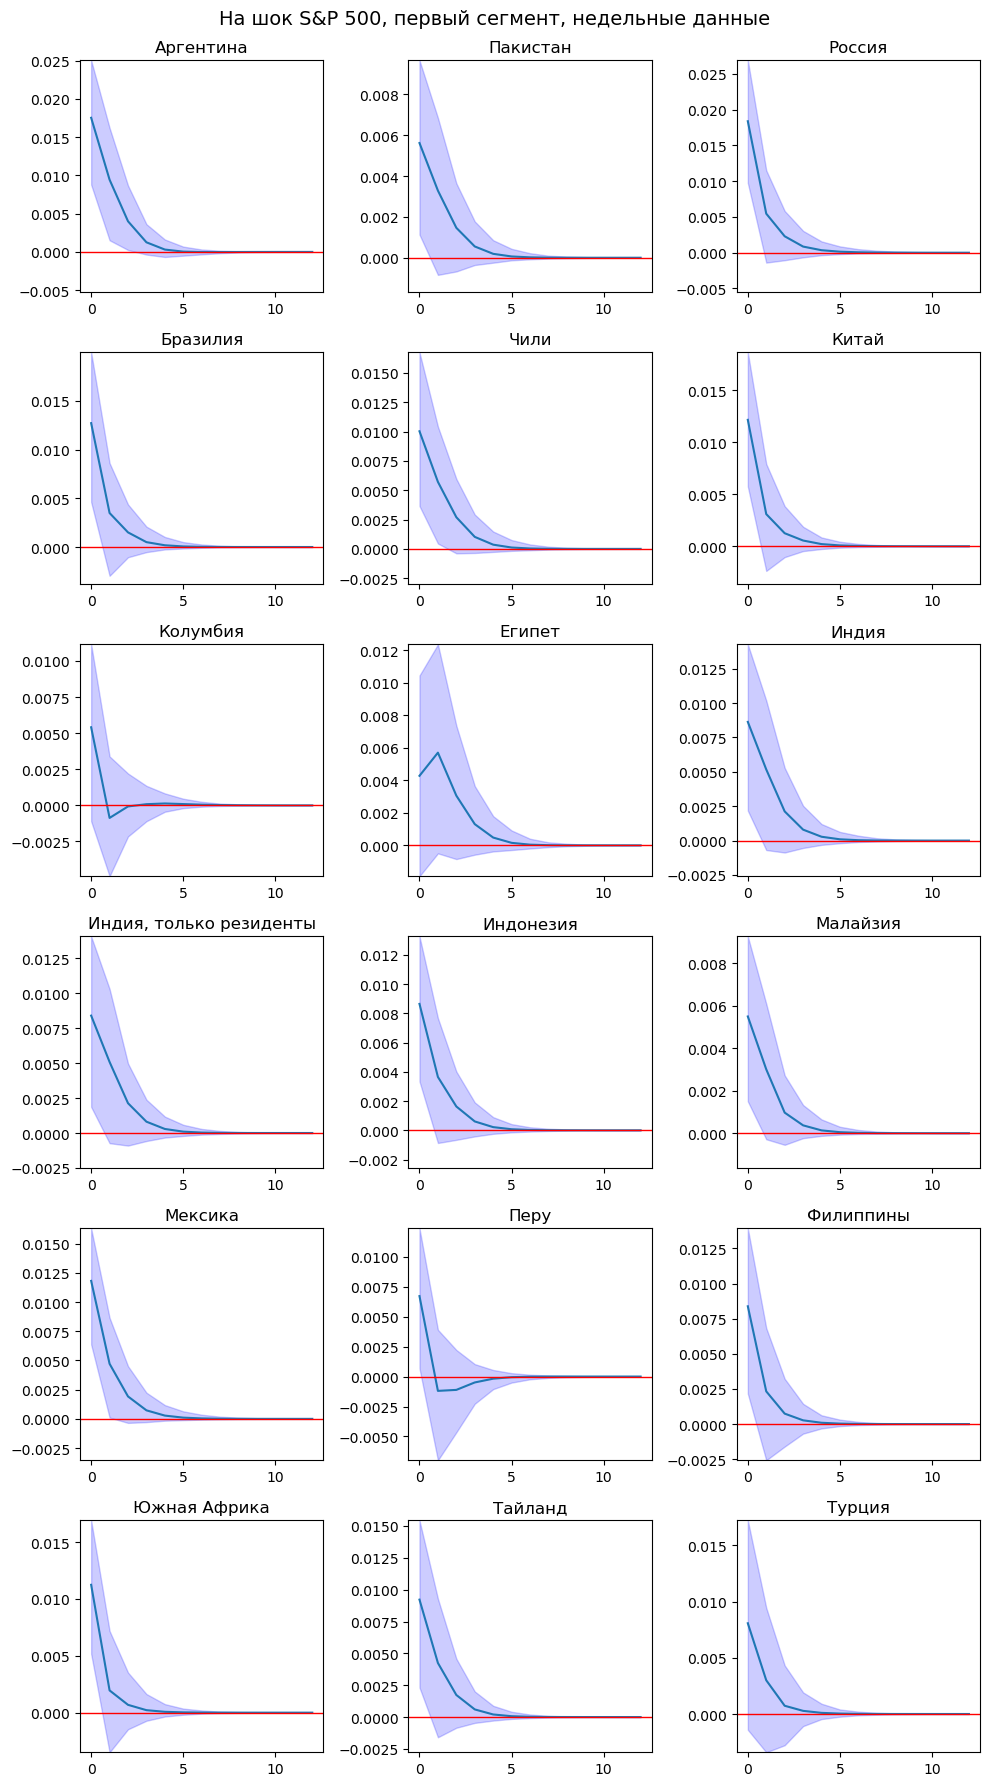

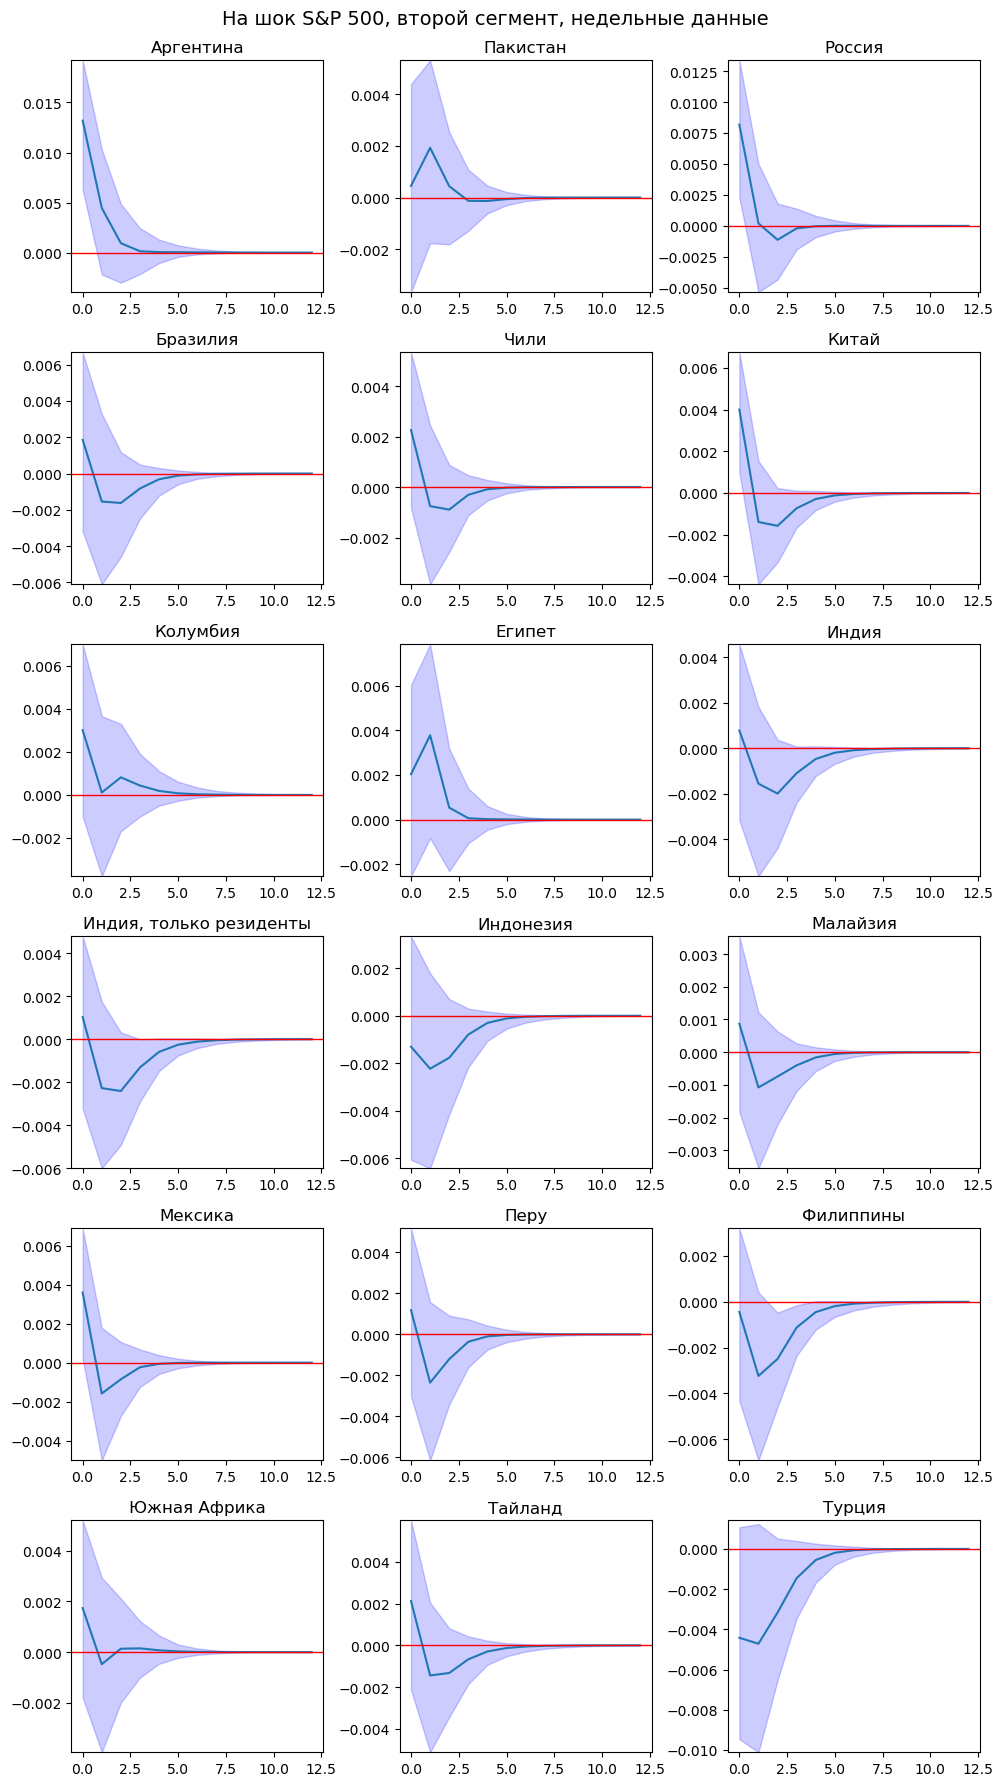

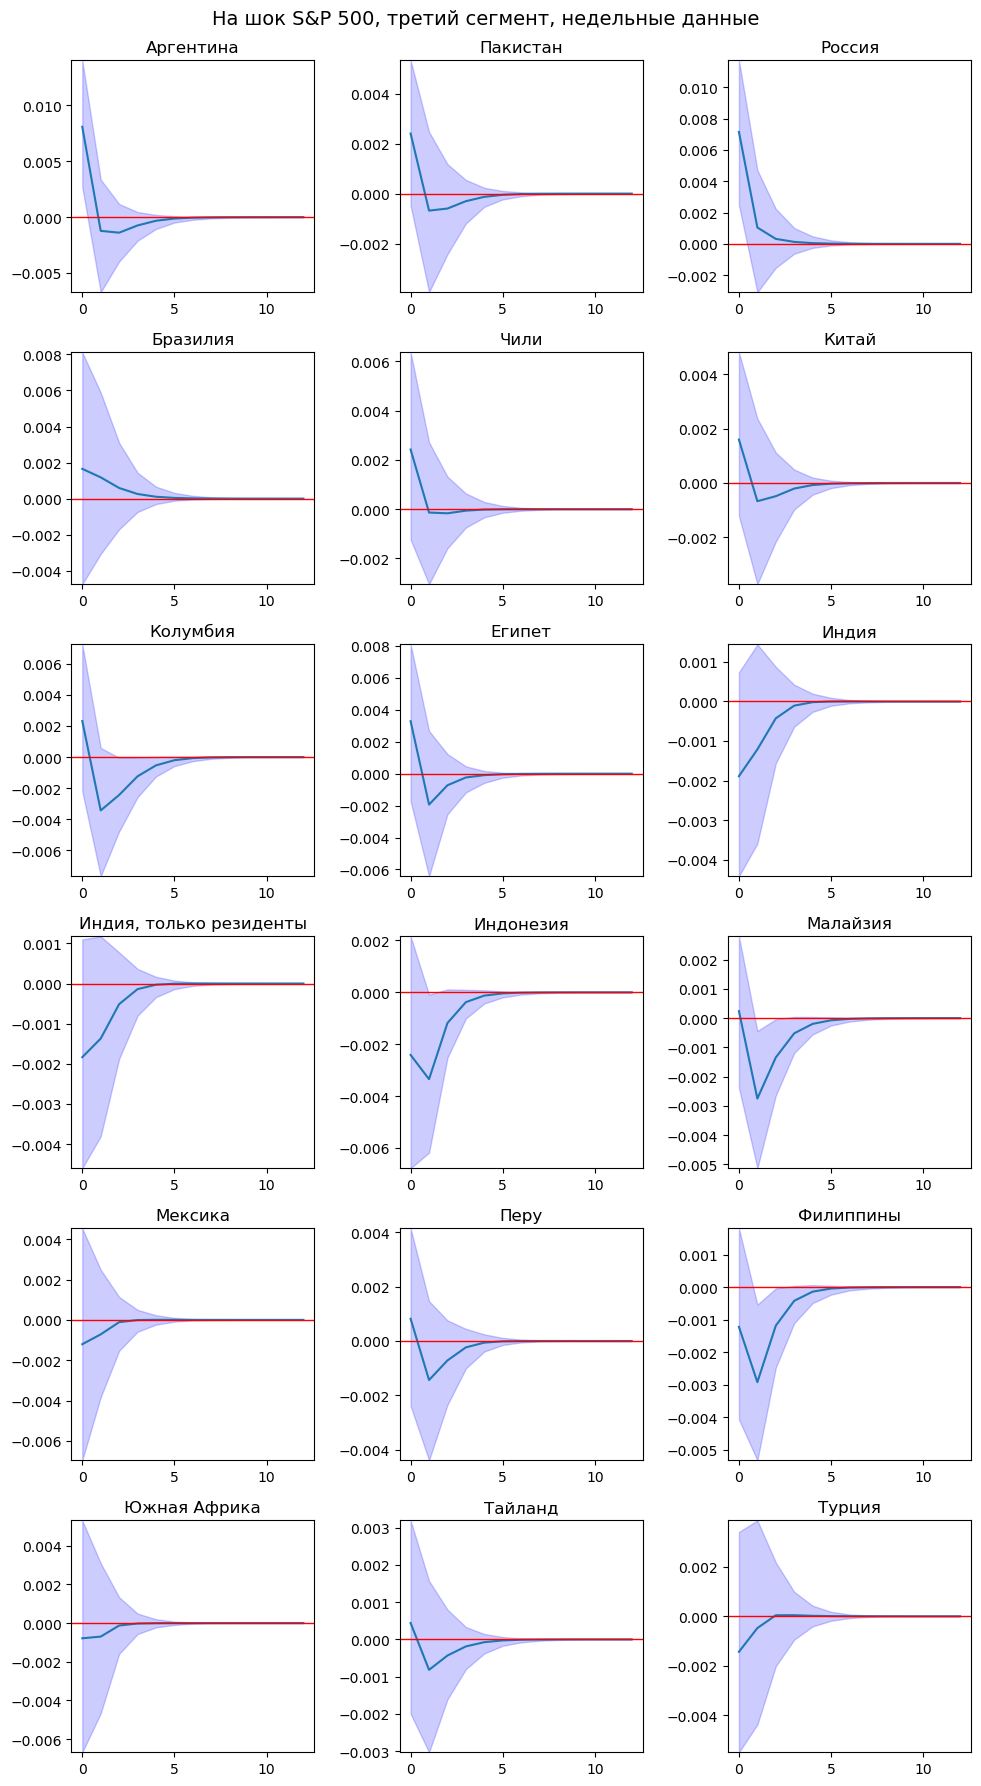

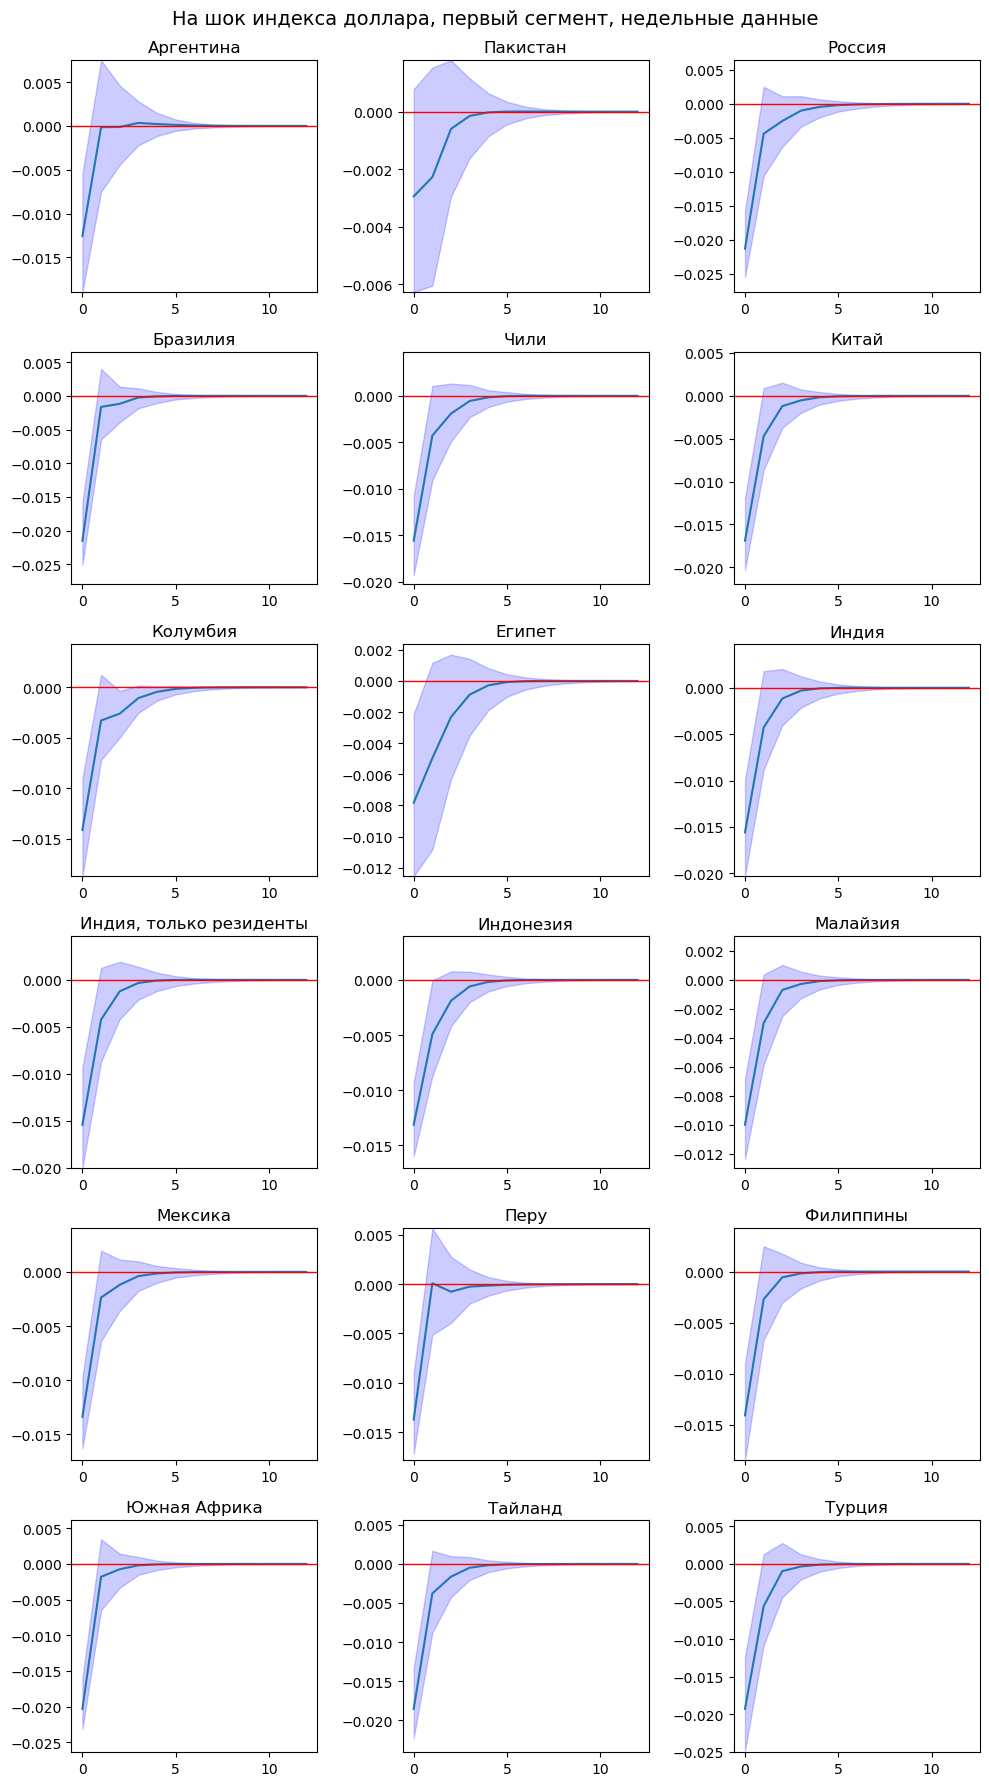

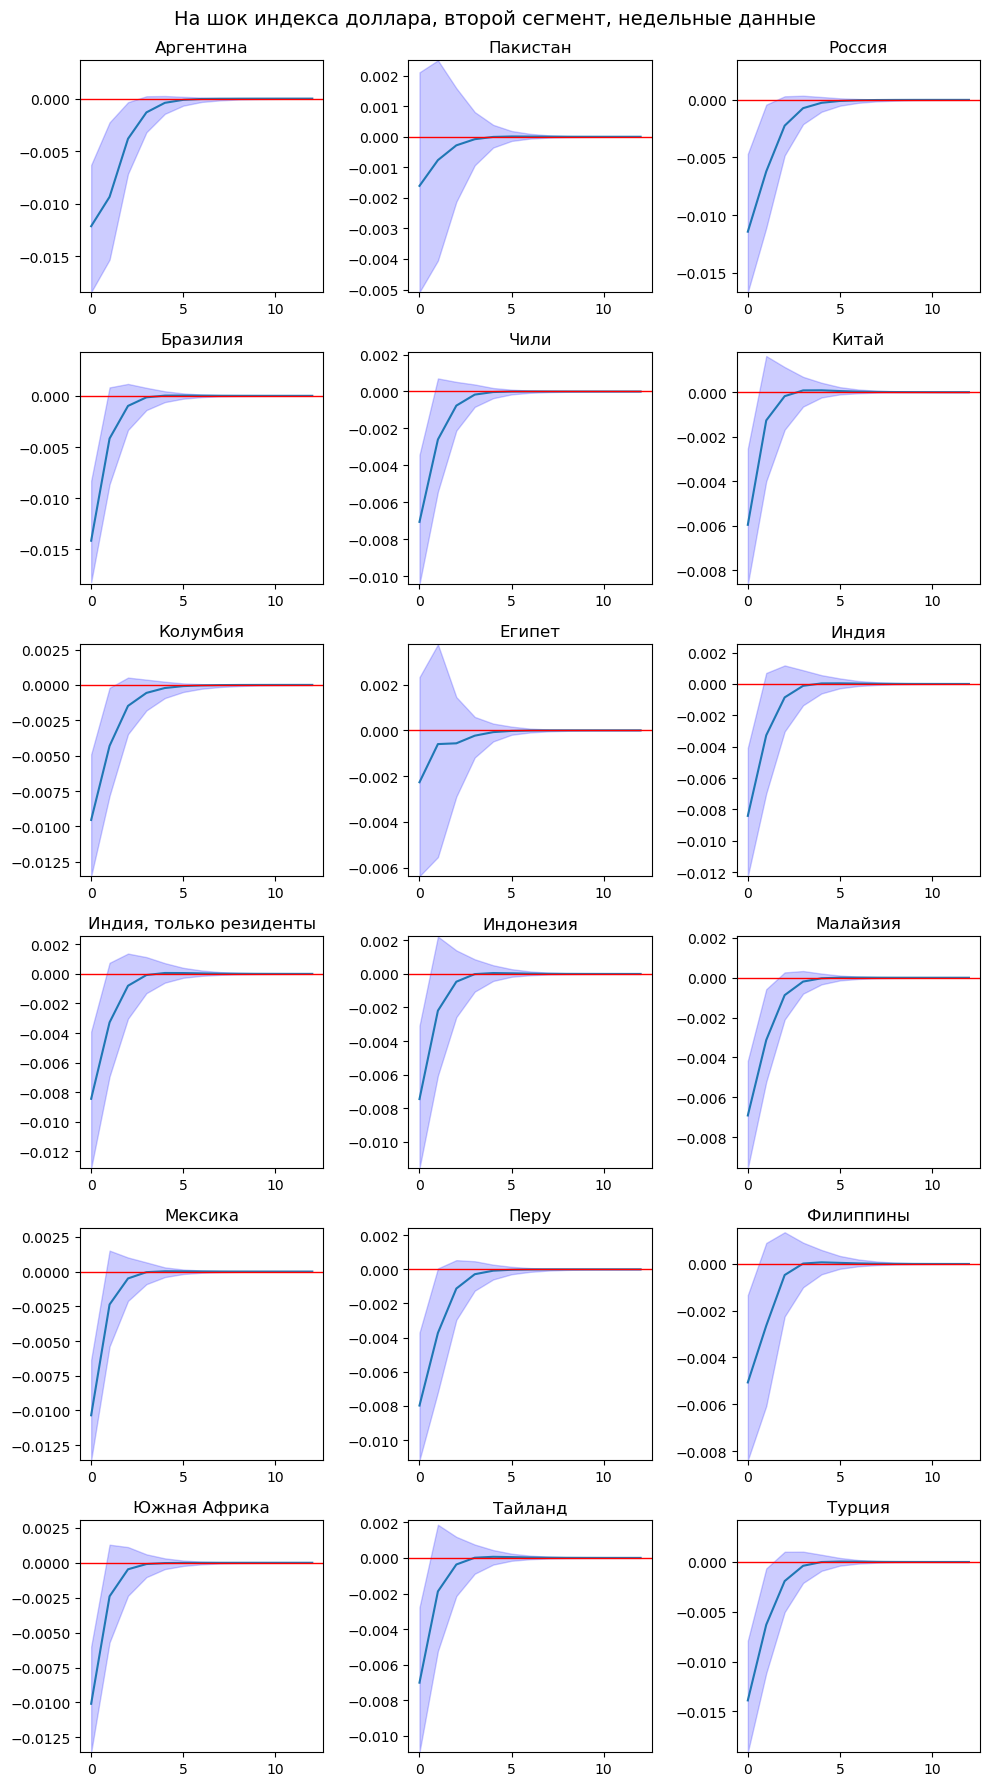

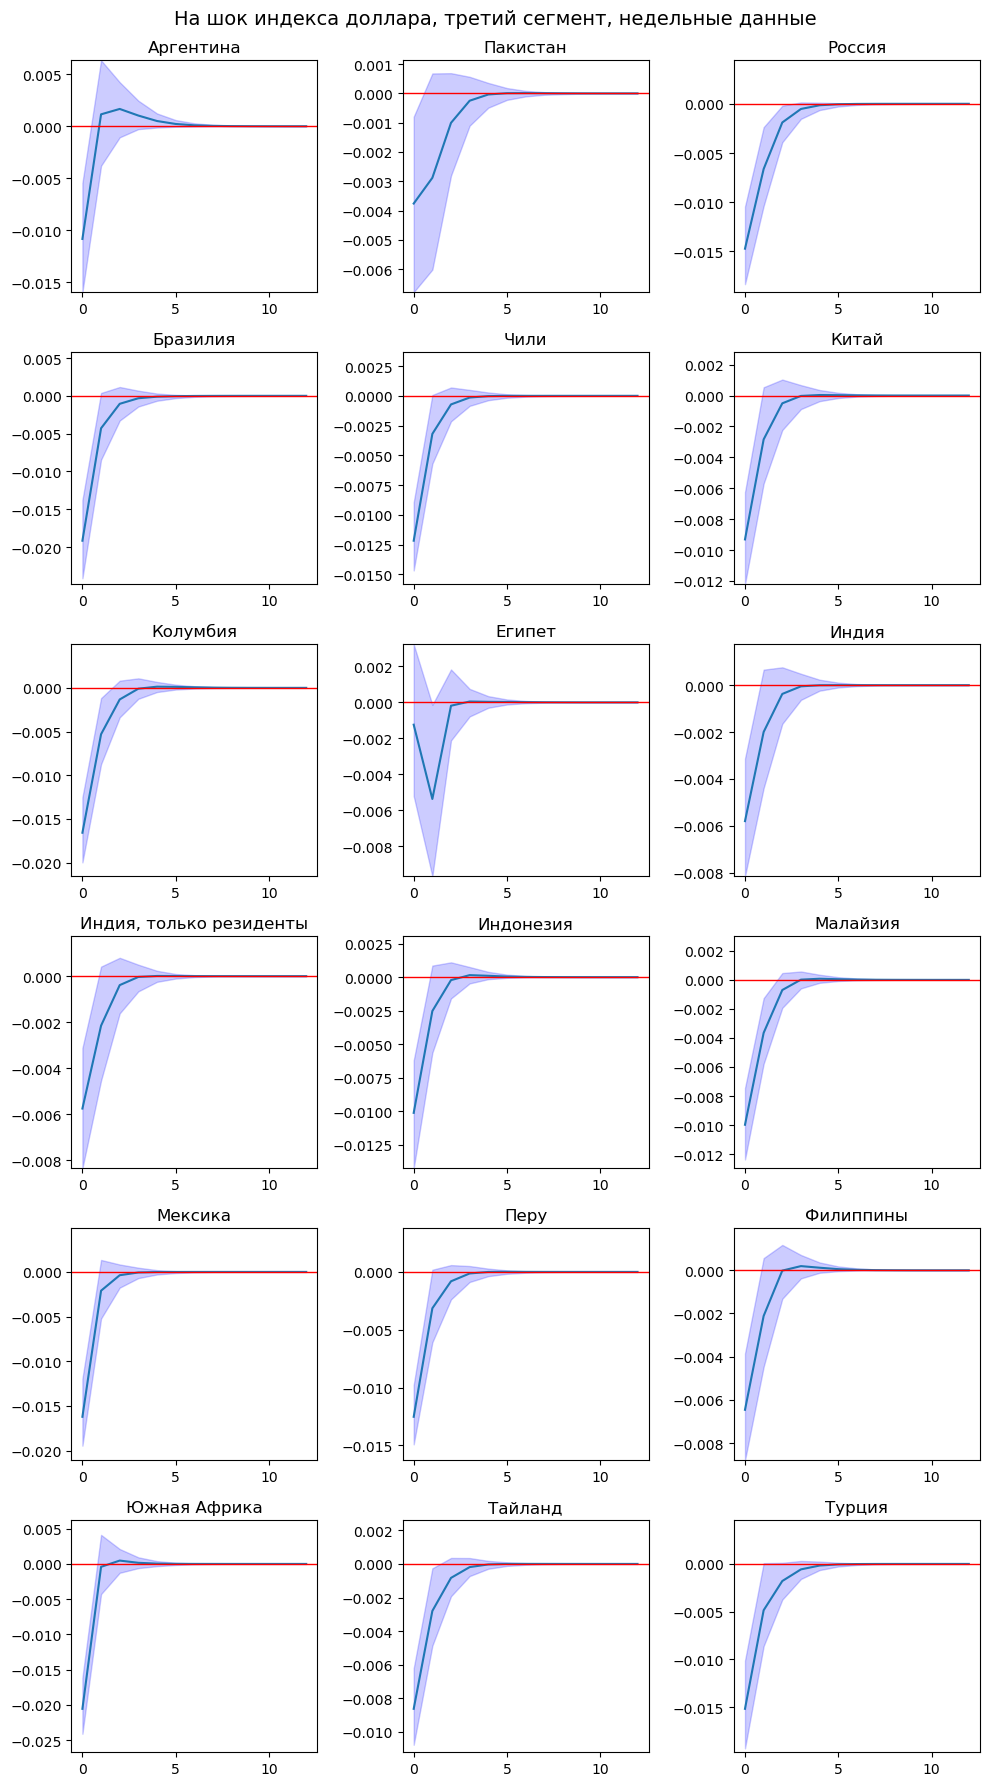

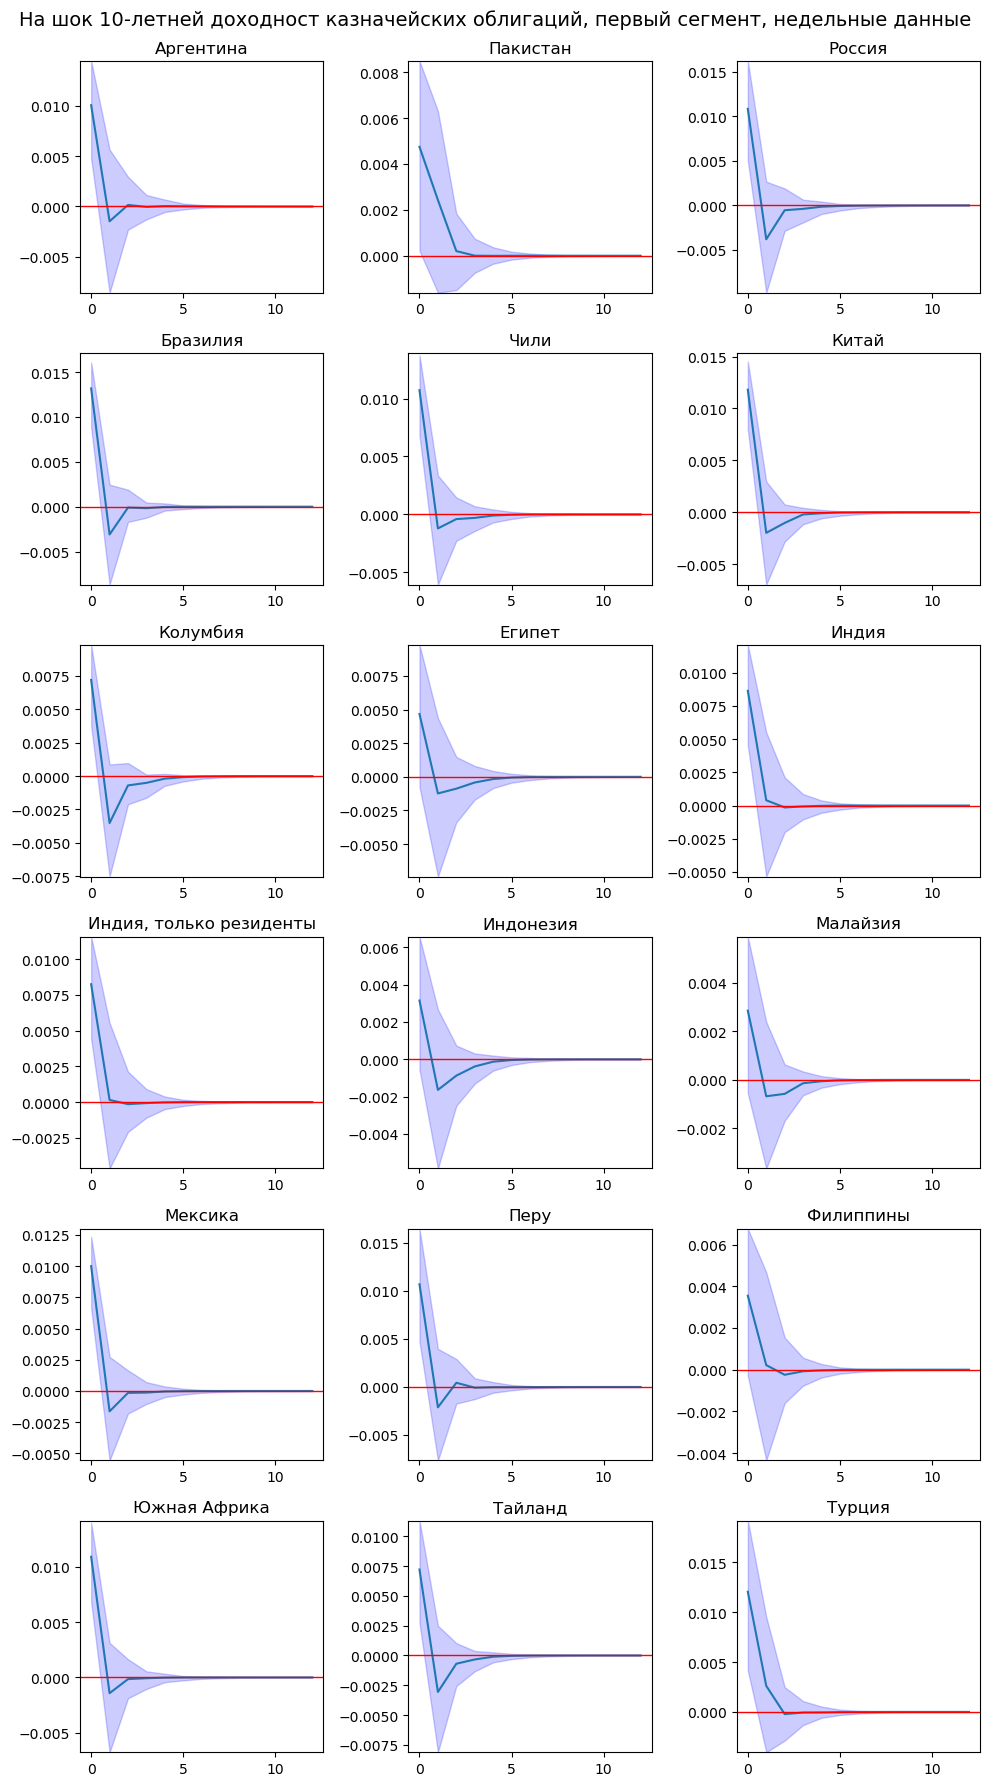

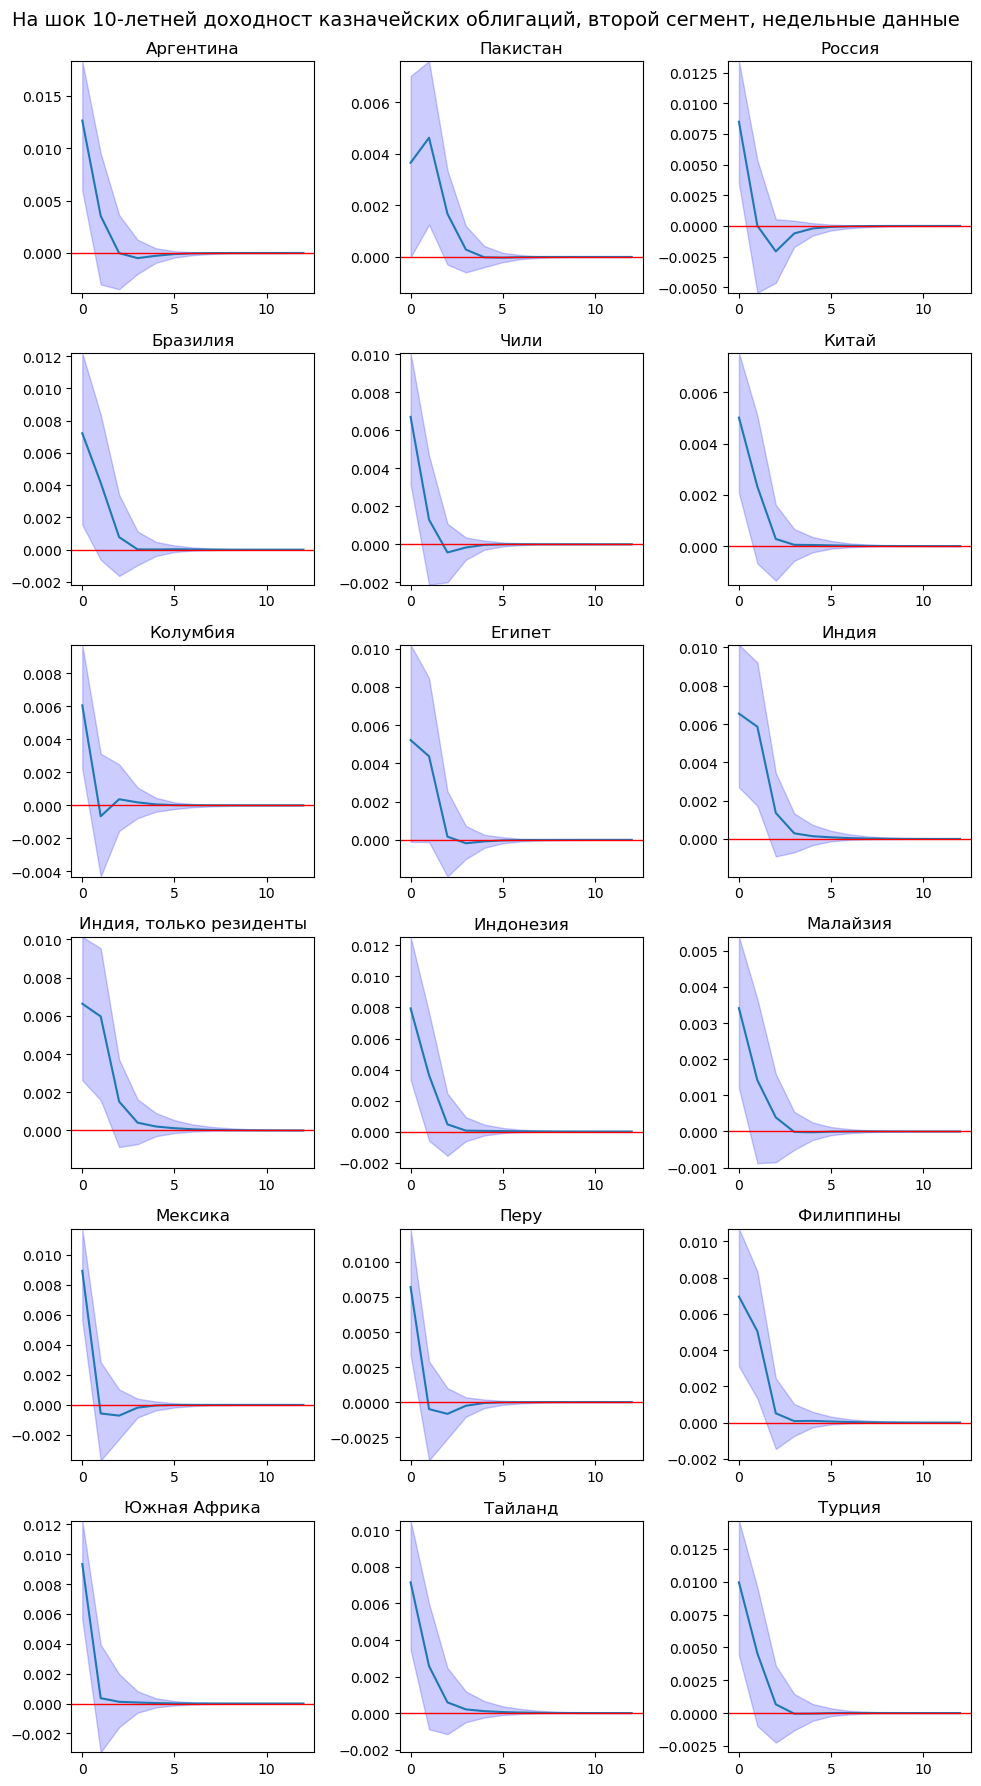

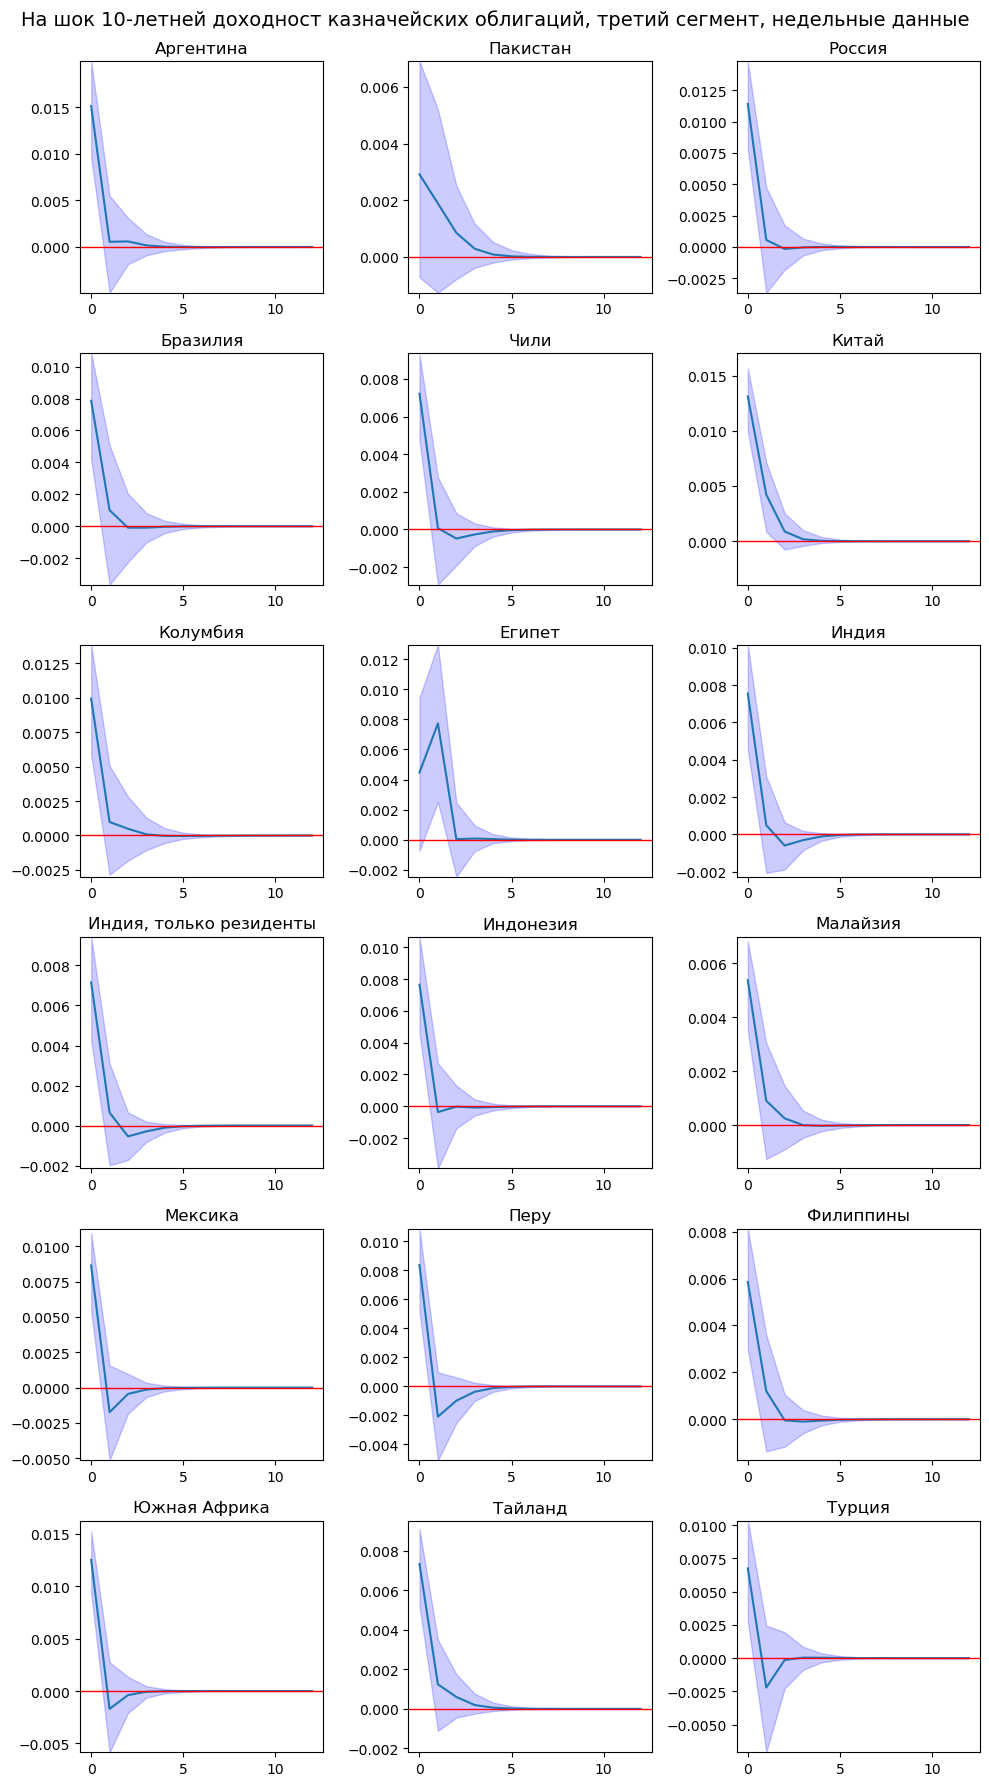

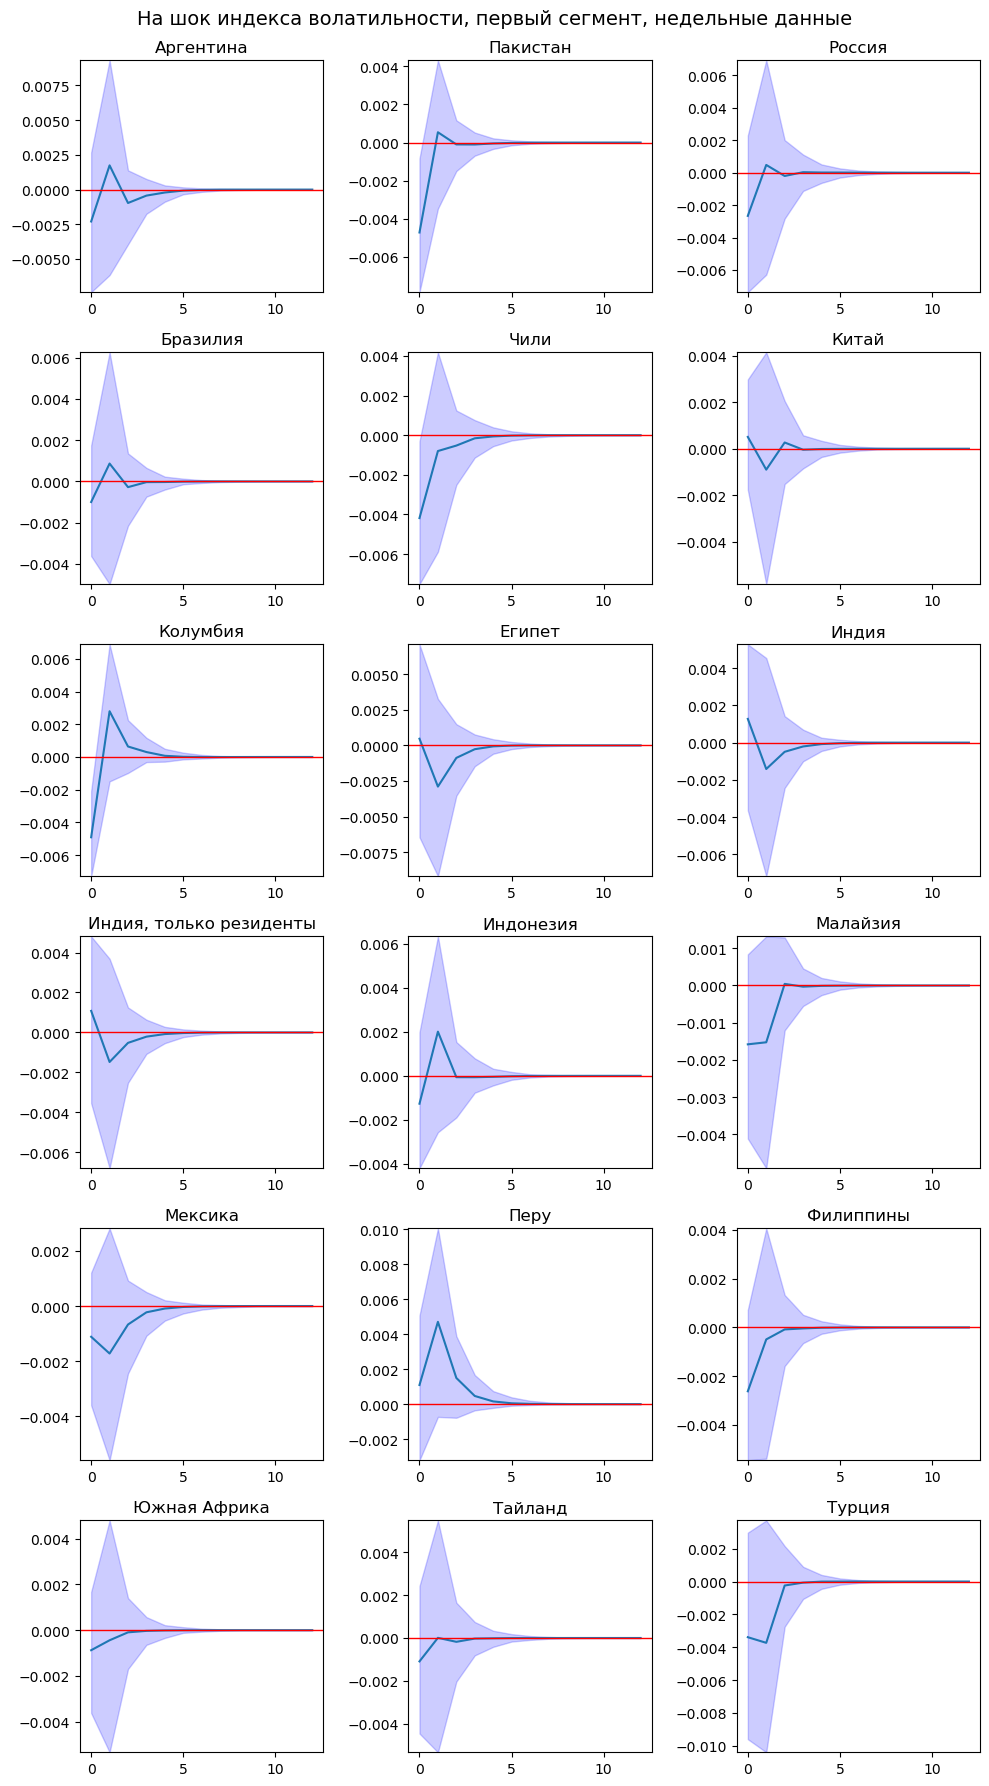

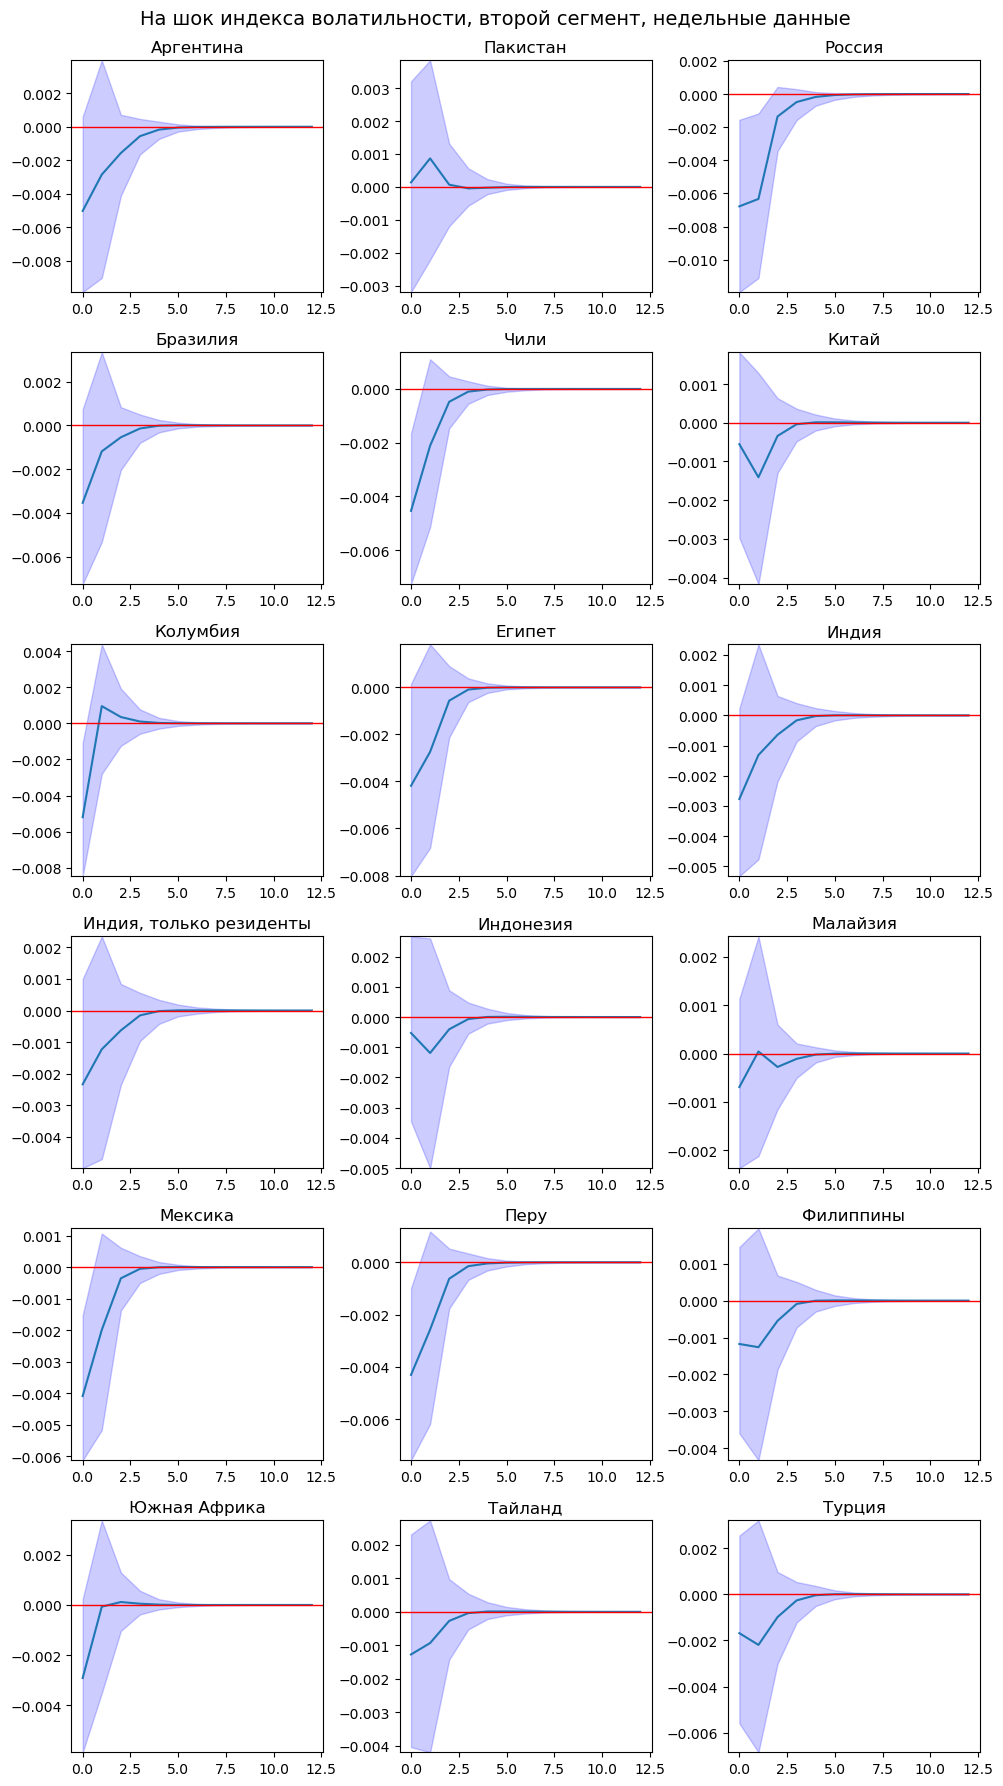

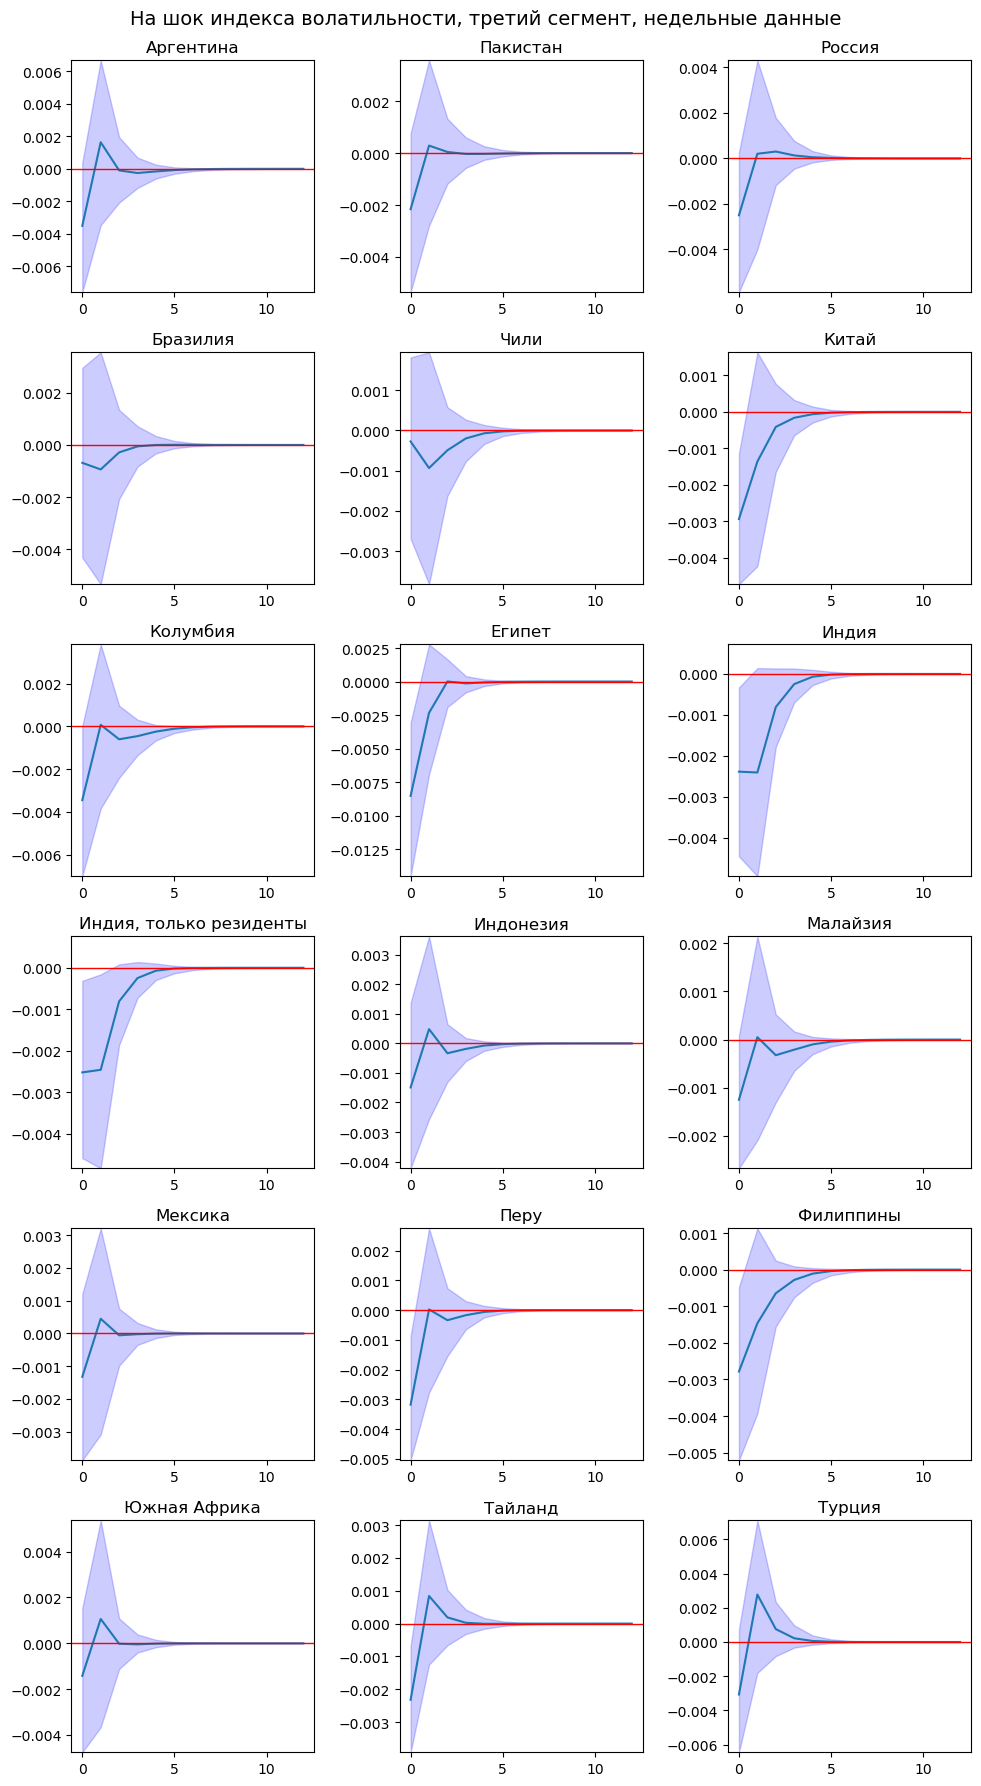

In [16]:
frequancy = {'weekly':'недельные данные', 'daily':'дневные данные'}
segment = {'1': 'первый сегмент', '2':'второй сегмент', '3':'третий сегмент'}
impulse = {'10y': '10-летней доходност казначейских облигаций', 'DXY':'индекса доллара', 
           'SP': 'S&P 500', 'VIX':'индекса волатильности'}
keys = []
for i in range(6):
    for j in range(3):
        keys.append(str(i)+str(j))
interat = {i: keys.index(i) for i in keys}
for freq in data_imp.freq.unique():
    for imp in data_imp.impulse.unique():
        for period in data_imp.period.unique():
            
            figure, axis = plt.subplots(6, 3, figsize=(10, 18))
            fig_name = f'Импульс на шок {impulse[imp]}, {segment[period]}, {frequancy[freq]}'
            for i in range(6):
                for j in range(3):
                    x = interat[str(i)+str(j)]

                    country = list(countries_rus.keys())[x]
                    temp_df = data_imp \
                    .query(f'country == "{country}" and freq == "{freq}" and period == "{period}" and impulse == "{imp}"')
                    y = temp_df.query("ci == 'irf'").iloc[:, :13].to_numpy().ravel()
                    ci1 = temp_df.query("ci == 'Lower'").iloc[:, :13].to_numpy().ravel()
                    ci2 = temp_df.query("ci == 'Upper'").iloc[:, :13].to_numpy().ravel()

                    axis[i, j].plot(range(13), y)
                    axis[i, j].fill_between(range(13), ci1, ci2, color='b', alpha=.2)
                    axis[i, j].axline((0,0), (12,0), linewidth = 1, color = 'r')
                    axis[i, j].set_ylim([min(y.min()*1.3, -y.max()*.3, ci1.min()), max(y.max()*1.3, -y.min()*.3, ci2.max())])
                    axis[i, j].set_title(countries_rus[country])

            figure.suptitle(f'На шок {impulse[imp]}, {segment[period]}, {frequancy[freq]}', y = .99, fontsize=14)
            figure.tight_layout()
            plt.savefig(f'C:/Users/vasil/YandexDisk/D is not for Dragons/plots & tables/new_ortho/{fig_name}.jpeg')

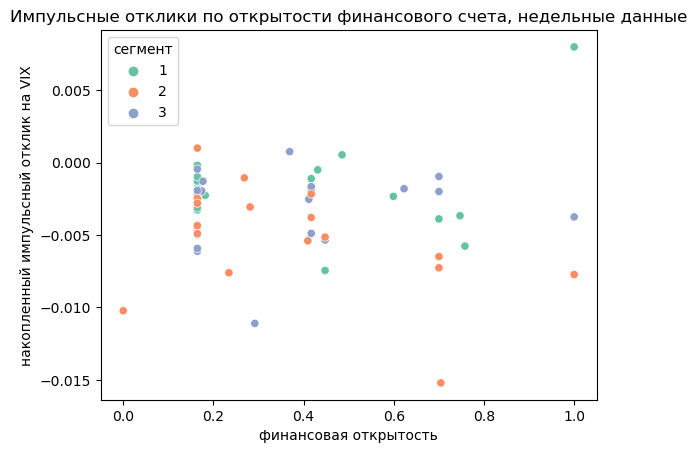

In [17]:
ax = sns.scatterplot(data = IMP.query('impulse == "VIX" and freq == "weekly"'), x = 'fo', y = 'cummulative',\
                hue = 'period', palette = 'Set2')
ax.set_title('Импульсные отклики по открытости финансового счета, недельные данные', wrap = True)
ax.set(xlabel='финансовая открытость', ylabel='накопленный импульсный отклик на VIX')
plt.legend(title='сегмент')
plt.savefig('a.jpeg')

In [ ]:
spec= pd.read_excel('specification.xlsx')

spec.iloc[:, 1] = [[*segment.values()][['first period', 'second period', 'third period'].index(i)] for i in spec.iloc[:, 1]]
spec.iloc[:, 2] = [countries_rus[i] for i in spec.iloc[:, 2]]
spec.iloc[:, 0] = [frequancy[i] for i in spec.iloc[:, 0]]

spec.style.set_caption("Таблица 8. Спецификация моделей").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '16px')
    ]
}])
spec.loc[:,'количество лагов'].value_counts()